In [32]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Scikit-learn imports
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Import randint for RandomizedSearchCV
from scipy.stats import randint

# For time series decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels not installed. Time series decomposition will be skipped.")

# Disable TensorFlow warnings for cleaner output (optional)
# import warnings
# warnings.filterwarnings("ignore")
# tf.get_logger().setLevel('ERROR')

# ## Section 1: Data Acquisition & Preprocessing


In [33]:
# --- Configuration ---
sensors_id = "12178556"  # Singapore PM2.5 Sensor ID
latitude = 1.3521      # Approximate coordinates for Singapore
longitude = 103.8198
location_name = "Singapore"

openaq_api_key = "4f1e60991c483fd961169d77137baa593d9568f4fa71585725860294b370bc43" # YOUR API KEY - User provided

# Define output filenames
base_processed_file = f'sensor_{sensors_id}_{location_name}_pm25_weather_hourly_data_processed_capped.csv'

# Initialize merged_df
merged_df = pd.DataFrame()

# --- Check if final processed data already exists ---
if os.path.exists(base_processed_file):
    print(f"Found fully processed data file: {base_processed_file}. Loading from disk.")
    try:
        merged_df = pd.read_csv(base_processed_file, index_col='timestamp', parse_dates=True)
        if not merged_df.empty:
            print(f"Successfully loaded processed data. Shape: {merged_df.shape}")
        else:
            print(f"Loaded processed data file is empty. Will attempt to re-fetch and process.")
            merged_df = pd.DataFrame() # Ensure it's empty
    except Exception as e:
        print(f"Error loading processed data file: {e}. Will attempt to re-fetch and process.")
        merged_df = pd.DataFrame()

if merged_df.empty:
    print("No valid pre-processed data found or loaded file was empty. Proceeding with API data fetching and full processing...")

    # ### 1.1 Fetch PM2.5 Data from OpenAQ
    if openaq_api_key == "YOUR_OPENAQ_API_KEY": # Default check (in case user removes their key)
        print("CRITICAL WARNING: Please set your OpenAQ API key to fetch PM2.5 data.")
        # For automated runs, you might want to exit or raise an error here
        # exit()

    pollutant_parameter_name = "pm25"
    date_from_str = '2022-05-01' # Fetch up to 2 years of data
    date_to_str = '2024-04-30'

    all_pm25_records = []
    page = 1
    limit_per_page = 1000

    print(f"Attempting to fetch PM2.5 data for sensor {sensors_id} ({location_name}) from {date_from_str} to {date_to_str}")

    while True and openaq_api_key != "YOUR_OPENAQ_API_KEY":
        base_url = f"https://api.openaq.org/v3/sensors/{sensors_id}/hours"
        params = {
            "date_from": date_from_str, "date_to": date_to_str,
            "limit": limit_per_page, "page": page, "sort": "asc",
        }
        headers = {"X-API-Key": openaq_api_key, "accept": "application/json"}

        print(f"Fetching PM2.5 data - Page {page}...")
        response_pm25 = None
        try:
            response_pm25 = requests.get(base_url, params=params, headers=headers)
            response_pm25.raise_for_status()
            data_pm25 = response_pm25.json()

            results_pm25 = data_pm25.get('results', [])
            if not results_pm25:
                print(f"No more PM2.5 results found on page {page}. Ending fetch.")
                break

            print(f"Successfully fetched {len(results_pm25)} PM2.5 records on page {page}.")
            for result in results_pm25:
                all_pm25_records.append({
                    'timestamp': result['period']['datetimeFrom']['utc'],
                    'pm25_value': result['value']
                })
            if len(results_pm25) < limit_per_page:
                print("Last page for PM2.5 data reached.")
                break
            page += 1
            time.sleep(2)
        except Exception as e:
            print(f"Error during PM2.5 API request on page {page}: {e}")
            if response_pm25 is not None:
                print(f"Status: {response_pm25.status_code}, Text: {response_pm25.text[:200]}")
            break

    aq_df_raw = pd.DataFrame()
    if all_pm25_records:
        aq_df_raw = pd.DataFrame(all_pm25_records)
        print(f"\nTotal raw PM2.5 records fetched: {len(aq_df_raw)}")
        if not aq_df_raw.empty:
            aq_df_raw['timestamp'] = pd.to_datetime(aq_df_raw['timestamp'], errors='coerce')
            aq_df_raw.dropna(subset=['timestamp'], inplace=True)
            if not aq_df_raw.empty:
                 print(f"Raw PM2.5 data ranges from: {aq_df_raw['timestamp'].min()} to {aq_df_raw['timestamp'].max()}")
    else:
        print("\nNo PM2.5 records fetched. Check API key, sensor ID, and date range.")

    aq_df_hourly = pd.DataFrame()
    if not aq_df_raw.empty:
        if 'timestamp' in aq_df_raw.columns and 'pm25_value' in aq_df_raw.columns:
            aq_df_raw.drop_duplicates(subset=['timestamp'], keep='first', inplace=True)
            if not aq_df_raw.empty:
                aq_df_raw.set_index('timestamp', inplace=True)
                aq_df_raw.sort_index(inplace=True)
                aq_df_raw['pm25_value'] = pd.to_numeric(aq_df_raw['pm25_value'], errors='coerce')
                aq_df_raw.dropna(subset=['pm25_value'], inplace=True)
                aq_df_raw = aq_df_raw[aq_df_raw['pm25_value'] >= 0]

                if not aq_df_raw.empty:
                    print("\n--- Raw PM2.5 Data Analysis Before Outlier Handling ---")
                    plt.figure(figsize=(10, 5))
                    sns.histplot(aq_df_raw['pm25_value'], kde=True, bins=50, color='orangered')
                    plt.title(f'Raw PM2.5 Distribution (Sensor {sensors_id} - {location_name}) Before Outlier Handling')
                    plt.xlabel('PM2.5 Concentration (µg/m³)'); plt.ylabel('Frequency')
                    plt.grid(True); plt.tight_layout(); plt.show()
                    print("Raw PM2.5 statistics before outlier capping:")
                    print(aq_df_raw['pm25_value'].describe())

                    PM25_CAP = 150.5 # Cap at the start of "Unhealthy" AQI category
                    print(f"\nCapping PM2.5 outliers at a fixed threshold: {PM25_CAP:.2f} µg/m³")

                    outliers_pm25_original = aq_df_raw[aq_df_raw['pm25_value'] > PM25_CAP].copy()
                    aq_df_raw['pm25_value'] = np.where(aq_df_raw['pm25_value'] > PM25_CAP, PM25_CAP, aq_df_raw['pm25_value'])

                    print("\n--- PM2.5 Data Analysis After Outlier Capping ---")
                    plt.figure(figsize=(10, 5))
                    sns.histplot(aq_df_raw['pm25_value'], kde=True, bins=30, color='lightseagreen') # Adjusted bins
                    plt.title(f'PM2.5 Distribution (Sensor {sensors_id} - {location_name}) After Capping at {PM25_CAP}')
                    plt.xlabel('PM2.5 Concentration (µg/m³)'); plt.ylabel('Frequency')
                    plt.grid(True); plt.tight_layout(); plt.show()
                    print("PM2.5 statistics after outlier capping:")
                    print(aq_df_raw['pm25_value'].describe())

                    plt.figure(figsize=(15,6))
                    plt.plot(aq_df_raw.index, aq_df_raw['pm25_value'], label=f'PM2.5 (Capped at {PM25_CAP})', color='dodgerblue')
                    if not outliers_pm25_original.empty:
                        plt.scatter(outliers_pm25_original.index, outliers_pm25_original['pm25_value'], color='red', label=f'Original Outliers (> {PM25_CAP})', zorder=5, s=20, alpha=0.7)
                    plt.title(f'PM2.5 Time Series with Original Outliers (> {PM25_CAP} µg/m³) Highlighted - {location_name}')
                    plt.xlabel('Timestamp'); plt.ylabel('PM2.5 (µg/m³)')
                    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

                    expected_pm25_range = pd.date_range(start=aq_df_raw.index.min(), end=aq_df_raw.index.max(), freq='h')
                    aq_df_hourly = aq_df_raw.reindex(expected_pm25_range).resample('h').mean()
                    aq_df_hourly.index.name = 'timestamp'
                    print(f"\nPM2.5 DataFrame after resampling (first 5 rows):\n{aq_df_hourly.head()}")
                else: print("PM2.5 DataFrame became empty after initial cleaning.")
            else: print("PM2.5 DataFrame became empty after duplicate drop.")
        else: print("Required PM2.5 columns not found.")
    else: print("Raw PM2.5 DataFrame is empty.")

    # ### 1.2 Fetch Meteorological Data
    weather_df_hourly = pd.DataFrame()
    if not aq_df_hourly.empty:
        print("\n--- Fetching Meteorological Data ---")
        weather_date_from = aq_df_hourly.index.min().strftime('%Y-%m-%d')
        weather_date_to = aq_df_hourly.index.max().strftime('%Y-%m-%d')
        print(f"Weather data will be fetched from {weather_date_from} to {weather_date_to} based on PM2.5 data range.")
        weather_url = "https://archive-api.open-meteo.com/v1/archive"
        weather_params = {
            "latitude": latitude, "longitude": longitude,
            "start_date": weather_date_from, "end_date": weather_date_to,
            "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,precipitation",
            "timezone": "GMT"
        }
        print(f"Fetching weather data from Open-Meteo...")
        response_weather = None
        try:
            response_weather = requests.get(weather_url, params=weather_params)
            response_weather.raise_for_status()
            weather_data = response_weather.json()
            if 'hourly' in weather_data and weather_data['hourly']:
                weather_df_hourly = pd.DataFrame(weather_data['hourly'])
                weather_df_hourly['time'] = pd.to_datetime(weather_df_hourly['time'])
                weather_df_hourly.set_index('time', inplace=True)
                weather_df_hourly.index.name = 'timestamp'
                weather_df_hourly.rename(columns={
                    'temperature_2m': 'temp', 'relative_humidity_2m': 'humidity',
                    'wind_speed_10m': 'wind_speed', 'wind_direction_10m': 'wind_dir',
                    'precipitation': 'precipitation'
                }, inplace=True)
                print(f"Successfully fetched {len(weather_df_hourly)} weather records.")
            else:
                print("No 'hourly' data found in Open-Meteo response.")
                weather_df_hourly = pd.DataFrame()
        except Exception as e:
            print(f"Error fetching/parsing weather data: {e}")
            if response_weather is not None:
                print(f"Status: {response_weather.status_code}, Text: {response_weather.text[:200]}")
    else:
        print("Skipping weather data fetch as PM2.5 data is empty or failed to process.")

    # ### 1.3 Merge and Final Clean (only if data was fetched)
    if not aq_df_hourly.empty and not weather_df_hourly.empty:
        print("\n--- Merging PM2.5 and Weather Data ---")
        if aq_df_hourly.index.tzinfo is None: aq_df_hourly.index = aq_df_hourly.index.tz_localize('UTC')
        else: aq_df_hourly.index = aq_df_hourly.index.tz_convert('UTC')
        if weather_df_hourly.index.tzinfo is None: weather_df_hourly.index = weather_df_hourly.index.tz_localize('UTC')
        else: weather_df_hourly.index = weather_df_hourly.index.tz_convert('UTC')

        merged_df_fresh = pd.merge(aq_df_hourly, weather_df_hourly, left_index=True, right_index=True, how='inner')
        print(f"Shape of PM2.5 data before merge: {aq_df_hourly.shape}")
        print(f"Shape of Weather data before merge: {weather_df_hourly.shape}")
        print(f"Shape of Merged data: {merged_df_fresh.shape}")

        if not merged_df_fresh.empty:
            merged_df_fresh.index.name = 'timestamp'
            print("\nMissing values in fresh merged_df before final interpolation:")
            print(merged_df_fresh.isnull().sum())
            for col in merged_df_fresh.columns:
                merged_df_fresh[col] = merged_df_fresh[col].interpolate(method='linear', limit_direction='both')
            merged_df_fresh.dropna(inplace=True)
            print("\nMissing values after final interpolation and drop:")
            print(merged_df_fresh.isnull().sum())
            print(f"Shape of final df for modeling: {merged_df_fresh.shape}")
            if not merged_df_fresh.empty:
                merged_df_fresh.to_csv(base_processed_file) # Save to the base processed file
                print(f"\nMerged and cleaned data saved to {base_processed_file}")
                merged_df = merged_df_fresh.copy()
            else: print("Freshly merged DataFrame became empty after final cleaning.")
        else: print("Freshly merged DataFrame is empty.")
    elif not aq_df_hourly.empty:
        print("\nWeather data fetch failed or was empty. Proceeding with PM2.5 data only (freshly processed).")
        merged_df_fresh = aq_df_hourly.copy()
        merged_df_fresh.index.name = 'timestamp'
        print("\nMissing values in PM2.5 data before final interpolation:")
        print(merged_df_fresh.isnull().sum())
        if 'pm25_value' in merged_df_fresh.columns:
            merged_df_fresh['pm25_value'] = merged_df_fresh['pm25_value'].interpolate(method='linear', limit_direction='both')
        merged_df_fresh.dropna(inplace=True)
        print("\nMissing values after final interpolation and drop (PM2.5 only):")
        print(merged_df_fresh.isnull().sum())
        print(f"Shape of final PM2.5 df for modeling: {merged_df_fresh.shape}")
        if not merged_df_fresh.empty:
            merged_df_fresh.to_csv(base_processed_file) # Save to the base processed file
            print(f"\nCleaned PM2.5 data (only) saved to {base_processed_file}")
            merged_df = merged_df_fresh.copy()
        else: print("Freshly processed PM2.5 DataFrame became empty after final cleaning.")
    else:
        print("\nBoth PM2.5 and weather data fetching resulted in empty DataFrames. Cannot proceed with fresh data.")

if merged_df.empty:
    print("CRITICAL: merged_df is empty after Section 1. Further processing will likely fail.")
    # exit()

Found fully processed data file: sensor_12178556_Singapore_pm25_weather_hourly_data_processed_capped.csv. Loading from disk.
Successfully loaded processed data. Shape: (2189, 6)


Using merged_df from Section 1 for EDA.

--- Basic Exploration & Visualization ---

Descriptive Statistics (after potential outlier capping):
        pm25_value         temp     humidity   wind_speed     wind_dir  \
count  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000   
mean    149.908360    26.288990    86.585199     5.674280   149.898127   
std       5.903882     2.779808    13.274650     3.165622   133.021150   
min      48.000000    22.100000    52.000000     0.200000     1.000000   
25%     150.500000    24.000000    75.000000     3.500000    29.000000   
50%     150.500000    25.400000    92.000000     5.100000    73.000000   
75%     150.500000    28.600000    98.000000     7.400000   294.000000   
max     150.500000    33.400000   100.000000    19.800000   360.000000   

       precipitation  
count    2189.000000  
mean        0.410279  
std         1.519444  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.100000  
max    

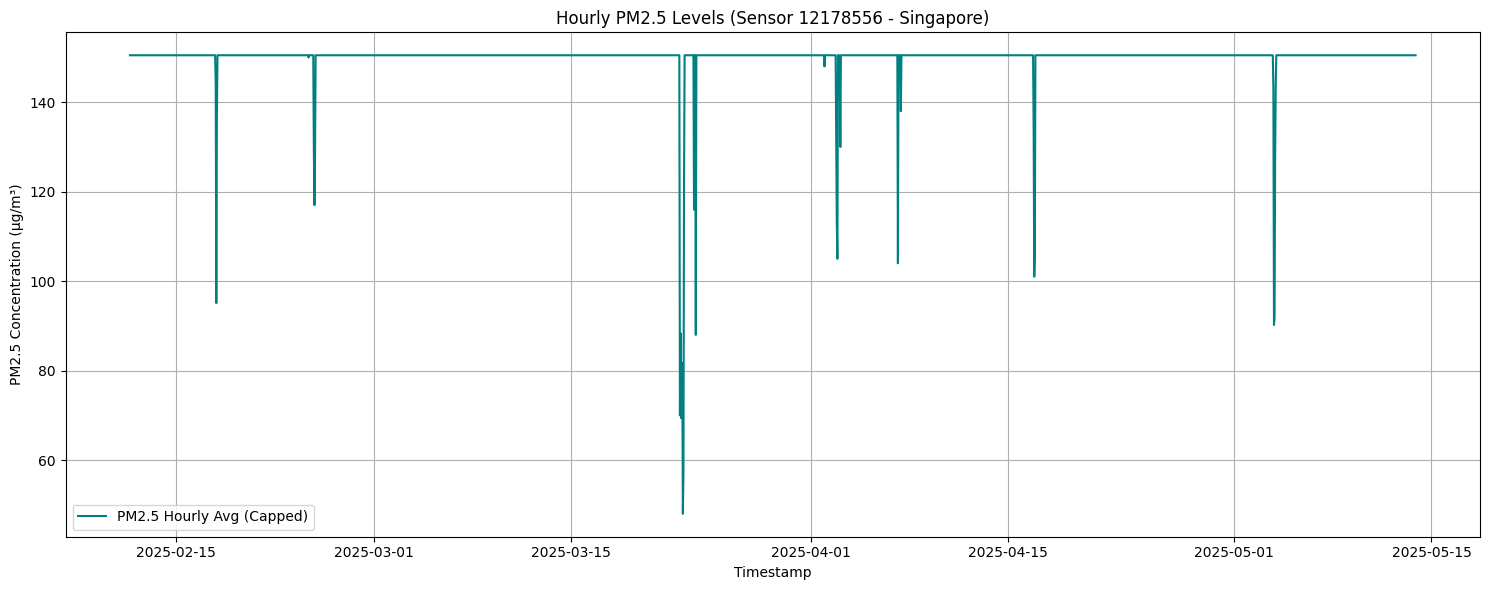

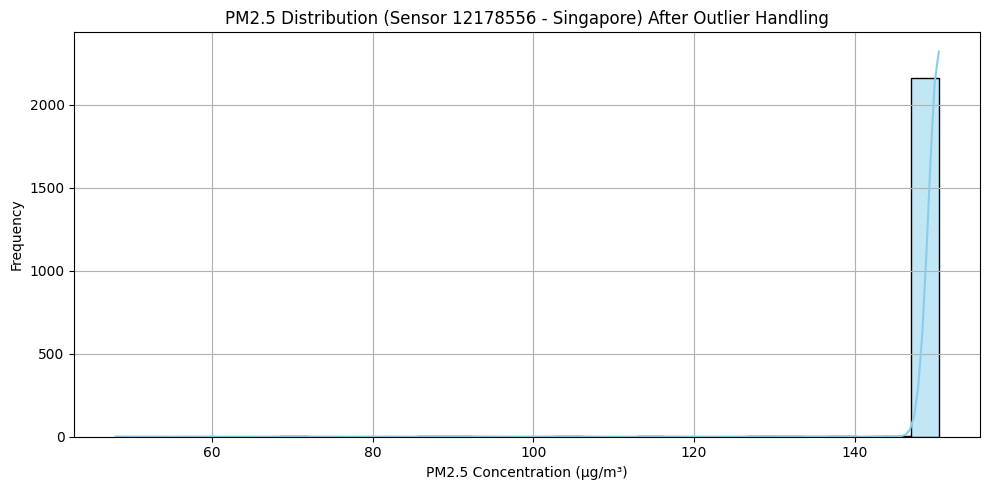

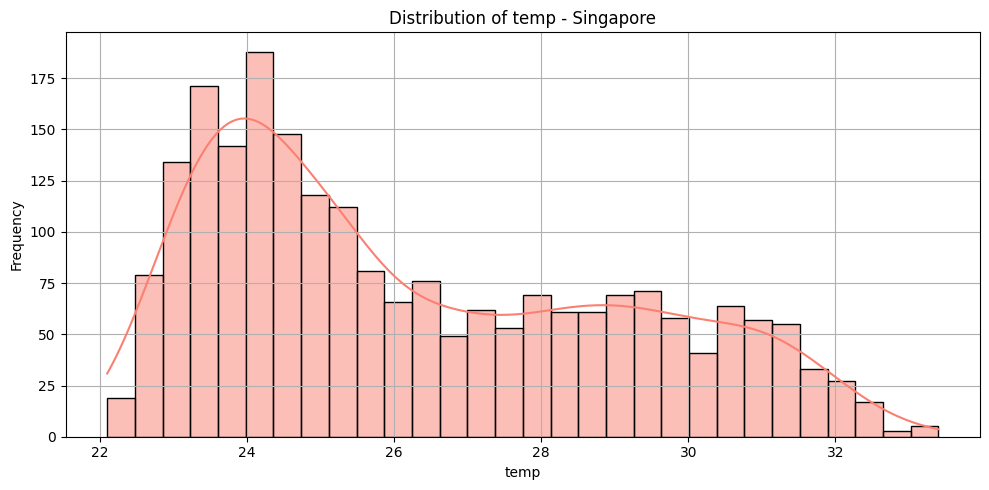

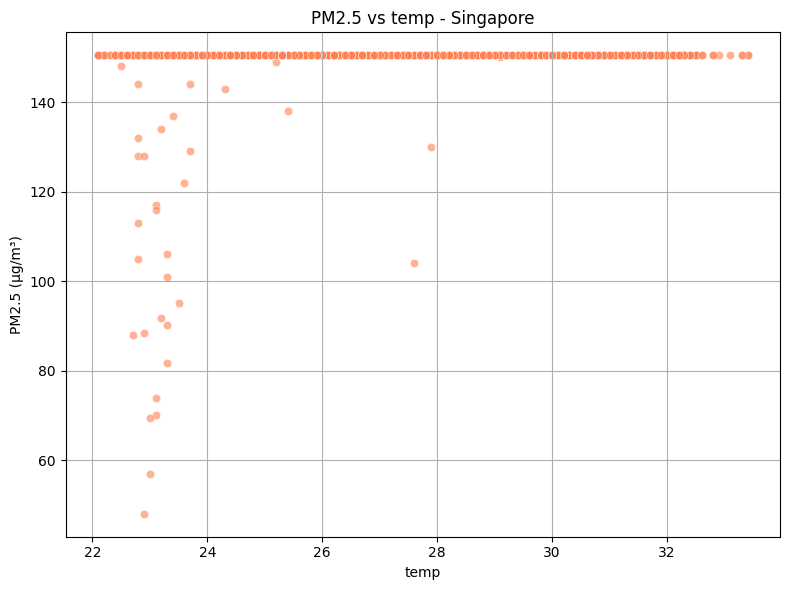

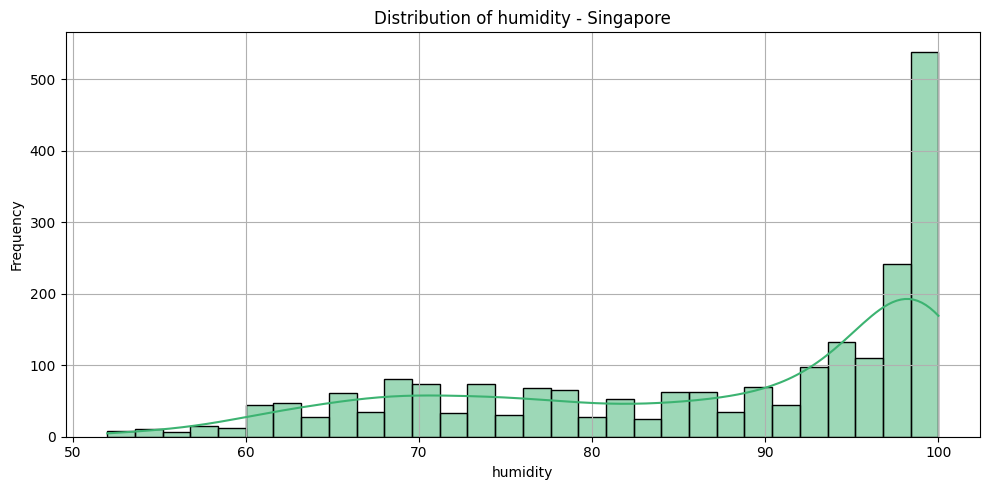

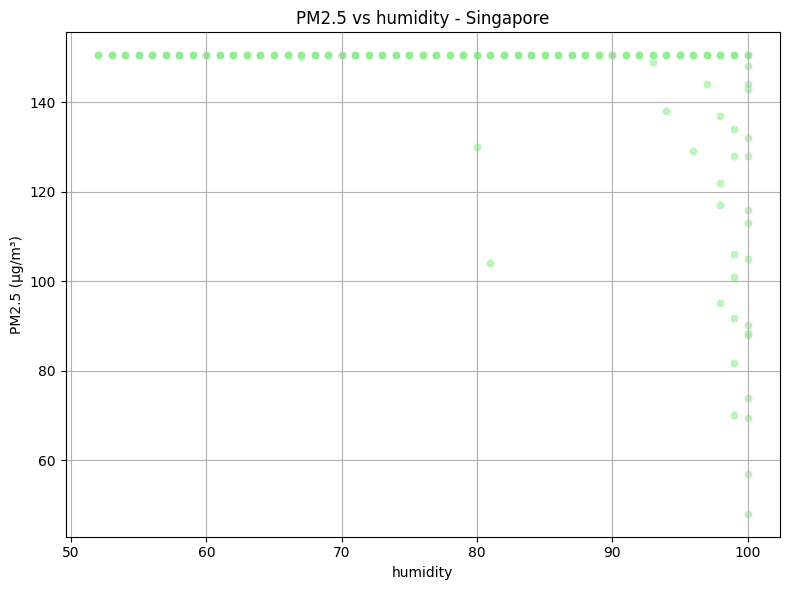

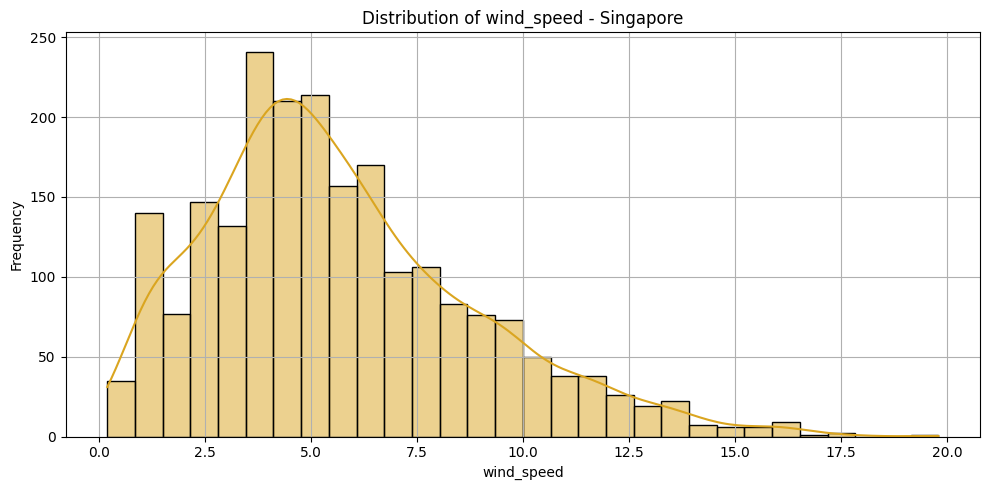

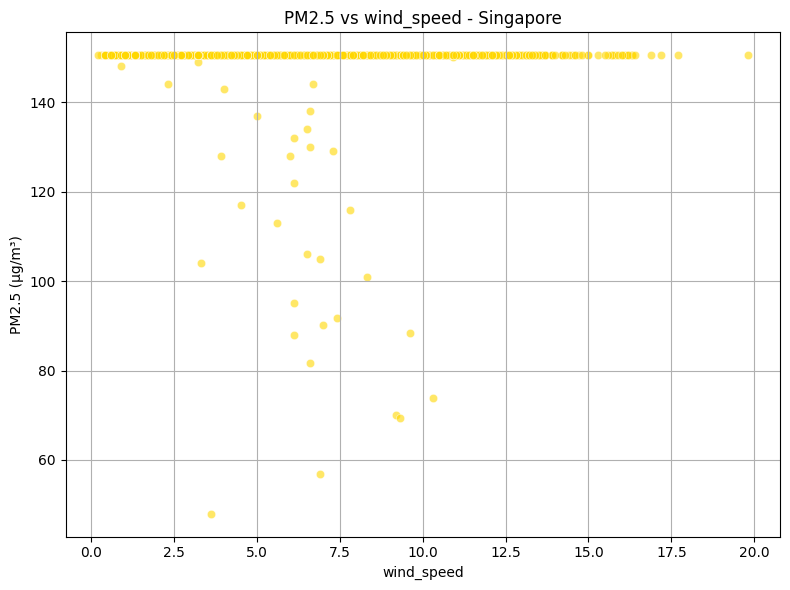

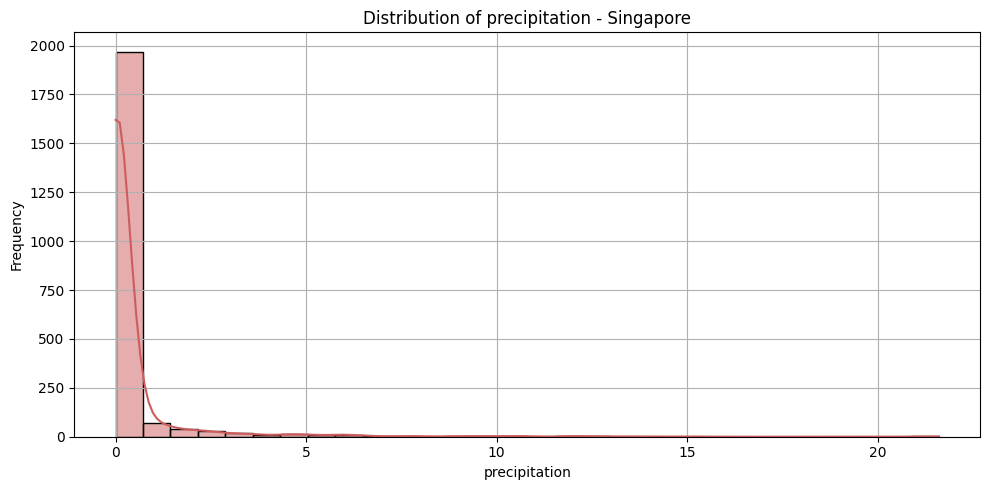

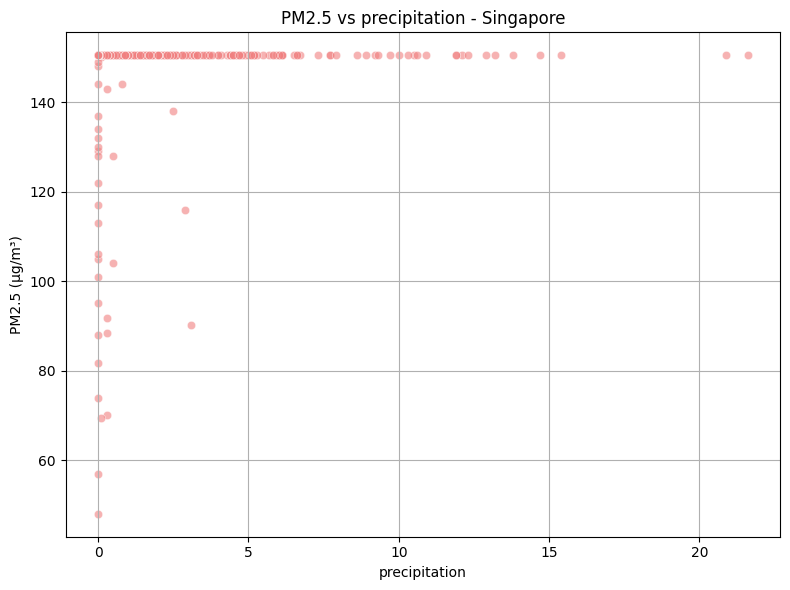

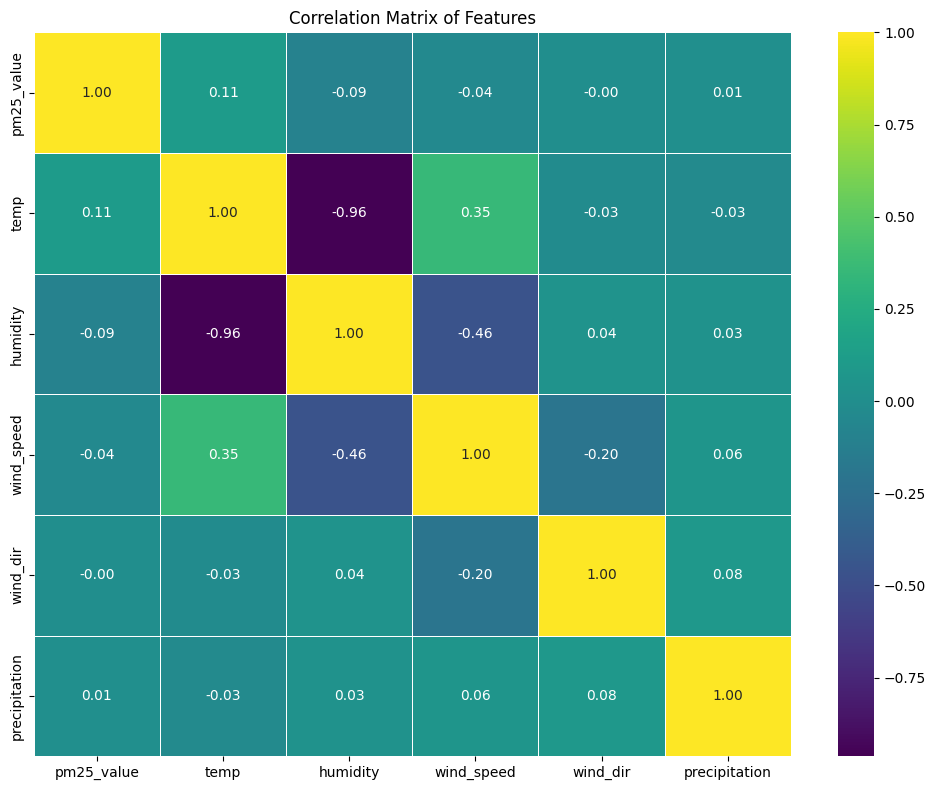

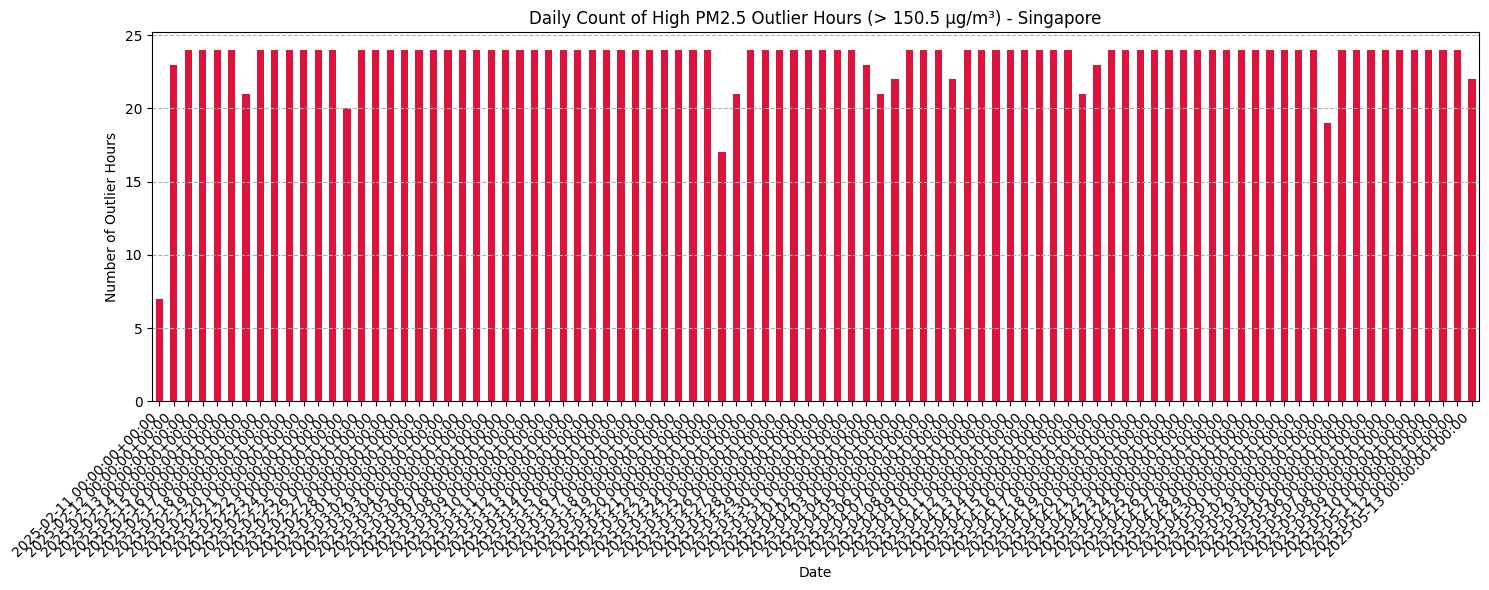

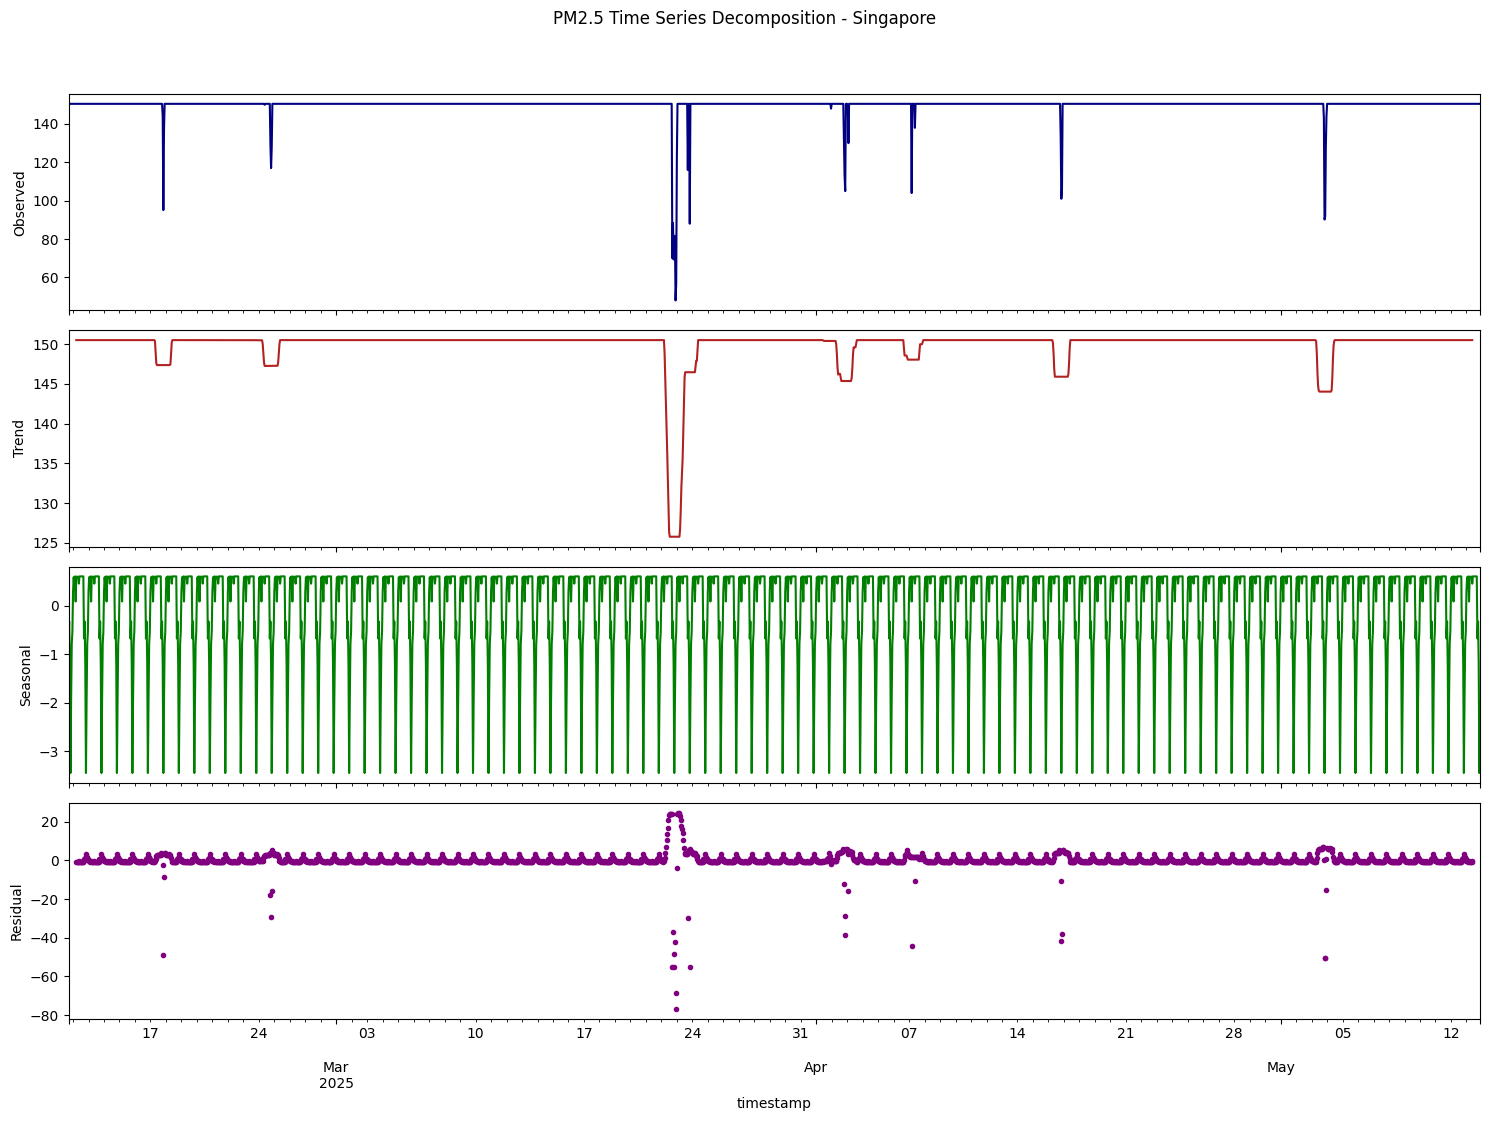

In [34]:
# ## Section 2: Exploratory Data Analysis (EDA)
df_for_eda = pd.DataFrame()
if not merged_df.empty:
    print("Using merged_df from Section 1 for EDA.")
    df_for_eda = merged_df.copy()
else:
    print("merged_df is empty from Section 1. Cannot proceed to EDA.")

if not df_for_eda.empty:
    print("\n--- Basic Exploration & Visualization ---")
    print("\nDescriptive Statistics (after potential outlier capping):")
    print(df_for_eda.describe())

    if 'pm25_value' in df_for_eda.columns:
        plt.figure(figsize=(15, 6)); plt.plot(df_for_eda.index, df_for_eda['pm25_value'], label='PM2.5 Hourly Avg (Capped)', color='teal')
        plt.title(f'Hourly PM2.5 Levels (Sensor {sensors_id} - {location_name})'); plt.xlabel('Timestamp'); plt.ylabel('PM2.5 Concentration (µg/m³)')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig(f'sensor_{sensors_id}_{location_name}_pm25_timeseries_plot.png'); plt.show()

        plt.figure(figsize=(10, 5)); sns.histplot(df_for_eda['pm25_value'], kde=True, bins=30, color='skyblue')
        plt.title(f'PM2.5 Distribution (Sensor {sensors_id} - {location_name}) After Outlier Handling')
        plt.xlabel('PM2.5 Concentration (µg/m³)'); plt.ylabel('Frequency')
        plt.grid(True); plt.tight_layout(); plt.savefig(f'sensor_{sensors_id}_{location_name}_pm25_distribution_plot.png'); plt.show()
    else:
        print("pm25_value column not found in df_for_eda for plotting.")

    weather_cols_for_eda = ['temp', 'humidity', 'wind_speed', 'precipitation']
    scatter_colors = ['coral', 'lightgreen', 'gold', 'lightcoral']
    hist_colors = ['salmon', 'mediumseagreen', 'goldenrod', 'indianred']

    for i, col in enumerate(weather_cols_for_eda):
        if col in df_for_eda.columns:
            plt.figure(figsize=(10,5))
            sns.histplot(df_for_eda[col], kde=True, bins=30, color=hist_colors[i % len(hist_colors)])
            plt.title(f'Distribution of {col} - {location_name}')
            plt.xlabel(col); plt.ylabel('Frequency')
            plt.grid(True); plt.tight_layout(); plt.savefig(f'sensor_{sensors_id}_{location_name}_{col}_distribution_plot.png'); plt.show()

            if 'pm25_value' in df_for_eda.columns:
                plt.figure(figsize=(8,6))
                sns.scatterplot(x=df_for_eda[col], y=df_for_eda['pm25_value'], color=scatter_colors[i % len(scatter_colors)], alpha=0.6)
                plt.title(f'PM2.5 vs {col} - {location_name}')
                plt.xlabel(col); plt.ylabel('PM2.5 (µg/m³)')
                plt.grid(True); plt.tight_layout(); plt.savefig(f'sensor_{sensors_id}_{location_name}_pm25_vs_{col}_plot.png'); plt.show()

    if 'temp' in df_for_eda.columns and 'pm25_value' in df_for_eda.columns: # Check if 'temp' exists before trying to use it in df_for_eda.corr()
        plt.figure(figsize=(10, 8)); sns.heatmap(df_for_eda.corr(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features'); plt.tight_layout(); plt.savefig(f'sensor_{sensors_id}_{location_name}_correlation_matrix.png'); plt.show()

    if 'outliers_pm25_original' in locals() and outliers_pm25_original is not None and not outliers_pm25_original.empty:
        daily_outlier_counts = outliers_pm25_original.resample('D').size()
        if not daily_outlier_counts.empty:
            plt.figure(figsize=(15,6))
            daily_outlier_counts.plot(kind='bar', color='crimson')
            plt.title(f'Daily Count of High PM2.5 Outlier Hours (> {PM25_CAP} µg/m³) - {location_name}')
            plt.xlabel('Date'); plt.ylabel('Number of Outlier Hours')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--'); plt.tight_layout()
            plt.savefig(f'sensor_{sensors_id}_{location_name}_daily_pm25_outlier_counts.png'); plt.show()
        else:
            print("No daily outlier counts to plot (outliers_pm25_original might be empty after resampling).")

    if 'pm25_value' in df_for_eda.columns and len(df_for_eda['pm25_value']) > 48 and STATSMODELS_AVAILABLE:
        try:
            decomposition = seasonal_decompose(df_for_eda['pm25_value'], model='additive', period=24)

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
            decomposition.observed.plot(ax=ax1, legend=False, color='navy'); ax1.set_ylabel('Observed')
            decomposition.trend.plot(ax=ax2, legend=False, color='firebrick'); ax2.set_ylabel('Trend')
            decomposition.seasonal.plot(ax=ax3, legend=False, color='green'); ax3.set_ylabel('Seasonal')
            decomposition.resid.plot(ax=ax4, legend=False, color='purple', marker='.', linestyle=''); ax4.set_ylabel('Residual')
            plt.suptitle(f'PM2.5 Time Series Decomposition - {location_name}', y=0.93)
            plt.tight_layout(rect=[0, 0, 1, 0.9]);
            plt.savefig(f'sensor_{sensors_id}_{location_name}_pm25_decomposition.png'); plt.show()
        except Exception as e: print(f"Error during time series decomposition: {e}")
    elif not STATSMODELS_AVAILABLE:
        print("Skipping time series decomposition as statsmodels is not available.")
    else:
        print("Not enough data or pm25_value column missing for seasonal decomposition with period 24.")

else:
    print("Skipping EDA as data is empty or failed to load.")

# ## Section 3 to 8: Modeling, Evaluation, Compression, and Conclusion
# These sections will be encapsulated in a loop to run for different forecast horizons.
# All filenames for models, plots, and results will include the forecast horizon.

In [35]:
# Define forecast horizons to test
forecast_horizons_to_test = [1, 6, 12, 24]
all_results_across_horizons = []

# Define AQI calculation and classification functions globally
def calculate_pm25_aqi(pm25_conc):
    if pd.isna(pm25_conc): return np.nan
    pm25_conc = float(pm25_conc)
    if pm25_conc < 0: return np.nan

    if 0.0 <= pm25_conc <= 12.0: aqi = round((50 - 0) / (12.0 - 0.0) * (pm25_conc - 0.0) + 0)
    elif 12.1 <= pm25_conc <= 35.4: aqi = round((100 - 51) / (35.4 - 12.1) * (pm25_conc - 12.1) + 51)
    elif 35.5 <= pm25_conc <= 55.4: aqi = round((150 - 101) / (55.4 - 35.5) * (pm25_conc - 35.5) + 101)
    elif 55.5 <= pm25_conc <= 150.4: aqi = round((200 - 151) / (150.4 - 55.5) * (pm25_conc - 55.5) + 151)
    elif 150.5 <= pm25_conc <= 250.4: aqi = round((300 - 201) / (250.4 - 150.5) * (pm25_conc - 150.5) + 201)
    elif 250.5 <= pm25_conc <= 350.4: aqi = round((400 - 301) / (350.4 - 250.5) * (pm25_conc - 250.5) + 301)
    elif 350.5 <= pm25_conc <= 500.4: aqi = round((500 - 401) / (500.4 - 350.5) * (pm25_conc - 350.5) + 401)
    elif pm25_conc > 500.4: aqi = 500
    else: aqi = 0 # Should ideally not happen with pm25_conc >= 0 check
    return int(aqi)

def get_aqi_category(aqi):
    if pd.isna(aqi): return "Unknown"
    aqi = int(aqi)
    if 0 <= aqi <= 50: return "Good"
    elif 51 <= aqi <= 100: return "Moderate"
    elif 101 <= aqi <= 150: return "Unhealthy for Sensitive Groups"
    elif 151 <= aqi <= 200: return "Unhealthy"
    elif 201 <= aqi <= 300: return "Very Unhealthy"
    elif aqi > 300: return "Hazardous"
    else: return "Unknown"
aqi_categories_list = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]


for forecast_horizon in forecast_horizons_to_test:
    print(f"\n\n===== PROCESSING FOR FORECAST HORIZON: {forecast_horizon} HOURS =====\n")

    # --- Section 3: Feature Engineering & Data Splitting ---
    df_for_modeling_h = pd.DataFrame()
    X_train, y_train, X_val, y_val, X_test, y_test = (pd.DataFrame() for _ in range(6)) # Initialize as empty DataFrames
    feature_cols = []

    if not df_for_eda.empty:
        df_for_modeling_h = df_for_eda.copy()
        print("\n--- Feature Engineering ---")
        if 'pm25_value' not in df_for_modeling_h.columns:
            print(f"Error: 'pm25_value' column missing for horizon {forecast_horizon}. Skipping this horizon.")
            continue

        df_for_modeling_h['target_pm25'] = df_for_modeling_h['pm25_value'].shift(-forecast_horizon)
        num_pm25_lags = 5
        for i in range(1, num_pm25_lags + 1):
            df_for_modeling_h[f'pm25_lag_{i}'] = df_for_modeling_h['pm25_value'].shift(i)
            feature_cols.append(f'pm25_lag_{i}')

        weather_features = ['temp', 'humidity', 'wind_speed', 'wind_dir', 'precipitation']
        num_weather_lags = 2
        for wf in weather_features:
            if wf in df_for_modeling_h.columns:
                for i in range(1, num_weather_lags + 1):
                    lag_col_name = f'{wf}_lag_{i}'
                    df_for_modeling_h[lag_col_name] = df_for_modeling_h[wf].shift(i)
                    feature_cols.append(lag_col_name)
            else: print(f"Weather feature '{wf}' not found, skipping its lags for horizon {forecast_horizon}.")

        df_for_modeling_h['hour'] = df_for_modeling_h.index.hour
        df_for_modeling_h['dayofweek'] = df_for_modeling_h.index.dayofweek
        df_for_modeling_h['month'] = df_for_modeling_h.index.month
        feature_cols.extend(['hour', 'dayofweek', 'month'])

        original_rows = df_for_modeling_h.shape[0]
        df_for_modeling_h.dropna(inplace=True)
        print(f"Shape after FE for horizon {forecast_horizon}: {df_for_modeling_h.shape} (dropped {original_rows - df_for_modeling_h.shape[0]} rows)")

        if df_for_modeling_h.empty:
            print(f"DataFrame empty after FE for horizon {forecast_horizon}. Skipping this horizon.")
            continue

        # Ensure only existing columns are used for X
        feature_cols = [col for col in feature_cols if col in df_for_modeling_h.columns]
        if not feature_cols:
            print(f"No feature columns available after checking existence for horizon {forecast_horizon}. Skipping this horizon.")
            continue

        X = df_for_modeling_h[feature_cols]
        y = df_for_modeling_h['target_pm25']

        total_samples = len(X)
        if total_samples < 60: # Increased minimum sample size
            print(f"Warning: Few samples ({total_samples}) for modeling for horizon {forecast_horizon}. Results might be unreliable. Skipping this horizon.")
            continue

        # Splitting: 70% train, 15% validation, 15% test
        train_end_idx = int(total_samples * 0.7)
        val_end_idx = int(total_samples * 0.85)

        X_train, y_train = X.iloc[:train_end_idx], y.iloc[:train_end_idx]
        X_val, y_val = X.iloc[train_end_idx:val_end_idx], y.iloc[train_end_idx:val_end_idx]
        X_test, y_test = X.iloc[val_end_idx:], y.iloc[val_end_idx:]

        print(f"\nData Split Shapes for horizon {forecast_horizon}:")
        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

        if X_train.empty or X_val.empty or X_test.empty:
            print(f"Error: Data splits are empty for horizon {forecast_horizon}. Skipping this horizon.")
            all_results_across_horizons.append({'Horizon': forecast_horizon, 'Model Type': 'Tuned RF', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (RF)': np.nan, 'AQI F1 (RF)': np.nan})
            all_results_across_horizons.append({'Horizon': forecast_horizon, 'Model Type': 'Baseline LSTM', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (LSTM)': np.nan, 'AQI F1 (LSTM)': np.nan})
            continue
    else:
        print(f"Skipping FE and Splitting for horizon {forecast_horizon} as EDA data is empty.")
        # Append NaN results if we skip a horizon early
        all_results_across_horizons.append({'Horizon': forecast_horizon, 'Model Type': 'Tuned RF', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (RF)': np.nan, 'AQI F1 (RF)': np.nan})
        all_results_across_horizons.append({'Horizon': forecast_horizon, 'Model Type': 'Baseline LSTM', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (LSTM)': np.nan, 'AQI F1 (LSTM)': np.nan})
        continue

    # --- Section 4: Model 1 - Random Forest Regressor ---
    rf_model_tuned = None
    tuned_rf_model_filename = f'sensor_{sensors_id}_{location_name}_rf_model_tuned_h{forecast_horizon}.joblib'

    if not X_train.empty:
        print(f"\n--- Hyperparameter Tuning for Random Forest (Horizon {forecast_horizon}h) ---")
        param_dist = {
            'n_estimators': randint(50, 150), # Reduced range
            'max_depth': [5, 10, 15], # Simplified depths
            'min_samples_split': randint(2, 6), # Reduced range
            'min_samples_leaf': randint(2, 6),  # Reduced range
            'max_features': ['sqrt', 'log2'] # Removed 1.0
        }
        rf_tuner = RandomForestRegressor(random_state=42, n_jobs=-1)
        tscv = TimeSeriesSplit(n_splits=3) # Standard 3 splits for time series

        # Reduced n_iter for RandomizedSearchCV for speed
        random_search_rf = RandomizedSearchCV(
            estimator=rf_tuner,
            param_distributions=param_dist,
            n_iter=5, # Reduced iterations
            cv=tscv,
            scoring='neg_mean_absolute_error',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        print("Starting RandomizedSearchCV for RF...")
        try:
            random_search_rf.fit(X_train, y_train)
            print(f"Best params for RF (h{forecast_horizon}): {random_search_rf.best_params_}")
            print(f"Best CV MAE for RF (h{forecast_horizon}): {-random_search_rf.best_score_:.4f}")
            rf_model_tuned = random_search_rf.best_estimator_

            if not X_val.empty:
                y_pred_val_rf_tuned = rf_model_tuned.predict(X_val)
                mae_val_rf_tuned = mean_absolute_error(y_val, y_pred_val_rf_tuned)
                rmse_val_rf_tuned = np.sqrt(mean_squared_error(y_val, y_pred_val_rf_tuned))
                print(f"Tuned RF (h{forecast_horizon}) - Val MAE: {mae_val_rf_tuned:.4f}, Val RMSE: {rmse_val_rf_tuned:.4f}")

            joblib.dump(rf_model_tuned, tuned_rf_model_filename)
            print(f"Tuned RF model (h{forecast_horizon}) saved to {tuned_rf_model_filename}")
        except ValueError as ve:
            print(f"ValueError during RF tuning for horizon {forecast_horizon}: {ve}. This might be due to too few samples for CV splits.")
            all_results_across_horizons.append({'Horizon': forecast_horizon, 'Model Type': 'Tuned RF', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (RF)': np.nan, 'AQI F1 (RF)': np.nan})
    else:
        print(f"Skipping RF tuning for horizon {forecast_horizon} as training data is not available.")
        all_results_across_horizons.append({'Horizon': forecast_horizon, 'Model Type': 'Tuned RF', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (RF)': np.nan, 'AQI F1 (RF)': np.nan})

    # --- Section 5: Model 2 - LSTM ---
    X_train_scaled, X_val_scaled, X_test_scaled = (None, None, None)
    y_train_scaled, y_val_scaled, y_test_scaled = (None, None, None)
    X_train_reshaped, X_val_reshaped, X_test_reshaped = (None, None, None)
    scaler_X, scaler_y = None, None
    lstm_model = None # Initialize lstm_model

    if not X_train.empty and not y_train.empty and not X_val.empty and not y_val.empty and not X_test.empty and not y_test.empty:
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val)
        X_test_scaled = scaler_X.transform(X_test)

        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
        # y_test_scaled will be transformed after prediction for consistency in inverse_transform

        n_features_lstm = X_train_scaled.shape[1]
        X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, n_features_lstm))
        X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, n_features_lstm))
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, n_features_lstm))

        lstm_model_filename = f'sensor_{sensors_id}_{location_name}_lstm_model_baseline_h{forecast_horizon}.keras'
        scaler_x_filename = f'sensor_{sensors_id}_{location_name}_scaler_X_h{forecast_horizon}.joblib'
        scaler_y_filename = f'sensor_{sensors_id}_{location_name}_scaler_y_h{forecast_horizon}.joblib'

        print(f"\n--- Implementing and Training LSTM (Horizon {forecast_horizon}h) ---")
        lstm_model = Sequential([
            Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
            LSTM(units=32, activation='tanh', recurrent_activation='sigmoid', # Reduced units
                 recurrent_dropout=0.1, return_sequences=False),
            Dense(units=1)
        ])
        lstm_model.compile(optimizer='adam', loss='mean_squared_error')
        # Reduced patience and epochs for speed
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        history_lstm = lstm_model.fit(
            X_train_reshaped, y_train_scaled,
            epochs=15, # Reduced epochs
            batch_size=32,
            validation_data=(X_val_reshaped, y_val_scaled),
            callbacks=[early_stopping],
            verbose=0
        )
        print("LSTM model training complete.")

        if X_val_reshaped.size > 0 and not y_val.empty: # Check if X_val_reshaped is not empty
            y_pred_val_scaled_lstm = lstm_model.predict(X_val_reshaped, verbose=0)
            y_pred_val_lstm = scaler_y.inverse_transform(y_pred_val_scaled_lstm)
            mae_val_lstm = mean_absolute_error(y_val, y_pred_val_lstm)
            rmse_val_lstm = np.sqrt(mean_squared_error(y_val, y_pred_val_lstm))
            print(f"Baseline LSTM (h{forecast_horizon}) - Val MAE: {mae_val_lstm:.4f}, Val RMSE: {rmse_val_lstm:.4f}")

        lstm_model.save(lstm_model_filename)
        joblib.dump(scaler_X, scaler_x_filename)
        joblib.dump(scaler_y, scaler_y_filename)
        print(f"Baseline LSTM model (h{forecast_horizon}) and scalers saved.")
    else:
        print(f"Skipping LSTM training for horizon {forecast_horizon} as training/validation/test data is not available or empty.")
        all_results_across_horizons.append({'Horizon': forecast_horizon, 'Model Type': 'Baseline LSTM', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (LSTM)': np.nan, 'AQI F1 (LSTM)': np.nan})

    # --- Section 6 (within loop): Final Model Evaluation & XAI (for this horizon) ---
    print(f"\n--- Final Model Evaluation on Test Set (Horizon {forecast_horizon}h) ---")
    rf_results_current_horizon = {'Horizon': forecast_horizon, 'Model Type': 'Tuned RF', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (RF)': np.nan, 'AQI F1 (RF)': np.nan}
    lstm_results_current_horizon = {'Horizon': forecast_horizon, 'Model Type': 'Baseline LSTM', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (LSTM)': np.nan, 'AQI F1 (LSTM)': np.nan}

    rf_model_loaded = None
    lstm_model_loaded = None
    scaler_y_loaded = None # Renamed from scaler_y_loaded_comp for clarity

    y_pred_test_rf = np.array([])
    y_pred_test_lstm = np.array([])

    if os.path.exists(tuned_rf_model_filename) and not X_test.empty:
        rf_model_loaded = joblib.load(tuned_rf_model_filename)
        print(f"Loaded tuned RF model from {tuned_rf_model_filename}")
        start_time_rf = time.time()
        y_pred_test_rf = rf_model_loaded.predict(X_test)
        rf_prediction_time = time.time() - start_time_rf

        mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
        rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
        rf_model_size = os.path.getsize(tuned_rf_model_filename) / (1024 * 1024)

        rf_results_current_horizon.update({
            'MAE': mae_test_rf,
            'RMSE': rmse_test_rf,
            'Pred Time (s/sample)': rf_prediction_time / len(X_test) if len(X_test) > 0 else 0,
            'Size (MB)': rf_model_size
        })
        print(f"Tuned RF (h{forecast_horizon}) - Test MAE: {mae_test_rf:.4f}, RMSE: {rmse_test_rf:.4f}")

        if hasattr(rf_model_loaded, 'feature_importances_') and forecast_horizon == 6 and 'feature_cols' in locals() and feature_cols:
            importances = rf_model_loaded.feature_importances_
            feature_names_rf = feature_cols
            if len(feature_names_rf) == len(importances): # Ensure lengths match
                feature_importance_df = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances}).sort_values(by='Importance', ascending=False)
                plt.figure(figsize=(10, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
                plt.title(f'Top 15 RF Features (h{forecast_horizon}) - {location_name}')
                plt.tight_layout()
                plt.savefig(f'sensor_{sensors_id}_{location_name}_rf_feat_imp_h{forecast_horizon}.png')
                plt.show()
            else:
                print(f"Warning: Length mismatch between feature_names_rf ({len(feature_names_rf)}) and importances ({len(importances)}) for RF h{forecast_horizon}.")
    else:
        print(f"Skipping RF eval for h{forecast_horizon} (model file or X_test missing).")
        # Ensure results are appended even if evaluation is skipped
        if rf_results_current_horizon['Horizon'] == forecast_horizon: # only append if it's for the current horizon
             all_results_across_horizons.append(rf_results_current_horizon)


    if os.path.exists(lstm_model_filename) and os.path.exists(scaler_y_filename) and X_test_reshaped is not None and not y_test.empty:
        lstm_model_loaded = load_model(lstm_model_filename)
        scaler_y_loaded = joblib.load(scaler_y_filename) # Use scaler_y_filename consistently
        print(f"\nLoaded LSTM model from {lstm_model_filename} and Y-scaler from {scaler_y_filename}.")

        start_time_lstm = time.time()
        y_pred_test_scaled_lstm = lstm_model_loaded.predict(X_test_reshaped, verbose=0)
        lstm_prediction_time = time.time() - start_time_lstm

        y_pred_test_lstm = scaler_y_loaded.inverse_transform(y_pred_test_scaled_lstm)

        mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
        rmse_test_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_lstm))
        lstm_model_size = os.path.getsize(lstm_model_filename) / (1024 * 1024)

        lstm_results_current_horizon.update({
            'MAE': mae_test_lstm,
            'RMSE': rmse_test_lstm,
            'Pred Time (s/sample)': lstm_prediction_time / len(X_test_reshaped) if len(X_test_reshaped) > 0 else 0,
            'Size (MB)': lstm_model_size
        })
        print(f"Baseline LSTM (h{forecast_horizon}) - Test MAE: {mae_test_lstm:.4f}, RMSE: {rmse_test_lstm:.4f}")
    else:
        print(f"Skipping LSTM eval for h{forecast_horizon} (model/scaler files or X_test_reshaped missing or y_test empty).")
        if lstm_results_current_horizon['Horizon'] == forecast_horizon: # only append if it's for the current horizon
            all_results_across_horizons.append(lstm_results_current_horizon)

    print(f"\n--- AQI Classification Evaluation on Test Set (Horizon {forecast_horizon}h) ---")
    if not y_test.empty:
        y_test_for_aqi = y_test.copy() # Use y_test directly
        y_test_aqi_series = y_test_for_aqi.apply(calculate_pm25_aqi).dropna()
        y_test_aqi_cat_series = y_test_aqi_series.apply(get_aqi_category)

        if forecast_horizon == 6 and not y_test_aqi_cat_series.empty:
            plt.figure(figsize=(10, 6))
            y_test_aqi_cat_series.value_counts().reindex(aqi_categories_list).fillna(0).plot(kind='bar', color='skyblue', alpha=0.8)
            plt.title(f'Distribution of Actual AQI Categories (Test Set, h{forecast_horizon}) - {location_name}')
            plt.xlabel('AQI Category'); plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha="right"); plt.tight_layout()
            plt.savefig(f'sensor_{sensors_id}_{location_name}_actual_aqi_dist_h{forecast_horizon}.png')
            plt.show()

        if y_pred_test_rf.size > 0:
            y_pred_rf_series = pd.Series(y_pred_test_rf, index=y_test_for_aqi.index) # Use y_test_for_aqi.index
            y_pred_rf_aqi = y_pred_rf_series.apply(calculate_pm25_aqi).dropna()
            y_pred_rf_aqi_cat = y_pred_rf_aqi.apply(get_aqi_category)

            if not y_test_aqi_cat_series.empty and not y_pred_rf_aqi_cat.empty:
                common_idx_rf = y_test_aqi_cat_series.index.intersection(y_pred_rf_aqi_cat.index)
                if not common_idx_rf.empty:
                    print(f"\nRandom Forest - AQI Category Classification Report (h{forecast_horizon}):")
                    report_rf = classification_report(y_test_aqi_cat_series.loc[common_idx_rf], y_pred_rf_aqi_cat.loc[common_idx_rf], labels=aqi_categories_list, zero_division=0, output_dict=True)
                    print(f"  Accuracy: {report_rf['accuracy']:.4f}, Weighted F1: {report_rf['weighted avg']['f1-score']:.4f}")
                    if 'MAE' in rf_results_current_horizon: # Check if dict has been updated
                        rf_results_current_horizon['AQI Accuracy (RF)'] = report_rf['accuracy']
                        rf_results_current_horizon['AQI F1 (RF)'] = report_rf['weighted avg']['f1-score']

                    if forecast_horizon == 6:
                        cm_rf = confusion_matrix(y_test_aqi_cat_series.loc[common_idx_rf], y_pred_rf_aqi_cat.loc[common_idx_rf], labels=aqi_categories_list)
                        plt.figure(figsize=(8,6)); sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
                        plt.title(f'RF AQI Confusion Matrix (h{forecast_horizon}) - {location_name}'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.savefig(f'sensor_{sensors_id}_{location_name}_rf_aqi_cm_h{forecast_horizon}.png'); plt.show()
                else:
                    print(f"No common valid (non-NaN AQI) indices for RF AQI classification (h{forecast_horizon}).")
            else:
                print(f"Actual or Predicted RF AQI categories are empty for h{forecast_horizon}.")
        else:
            print(f"No RF predictions to evaluate for AQI classification (h{forecast_horizon}).")

        if y_pred_test_lstm.size > 0:
            y_pred_lstm_series = pd.Series(y_pred_test_lstm.flatten(), index=y_test_for_aqi.index) # Use y_test_for_aqi.index
            y_pred_lstm_aqi = y_pred_lstm_series.apply(calculate_pm25_aqi).dropna()
            y_pred_lstm_aqi_cat = y_pred_lstm_aqi.apply(get_aqi_category)

            if not y_test_aqi_cat_series.empty and not y_pred_lstm_aqi_cat.empty:
                common_idx_lstm = y_test_aqi_cat_series.index.intersection(y_pred_lstm_aqi_cat.index)
                if not common_idx_lstm.empty:
                    print(f"\nLSTM - AQI Category Classification Report (h{forecast_horizon}):")
                    report_lstm = classification_report(y_test_aqi_cat_series.loc[common_idx_lstm], y_pred_lstm_aqi_cat.loc[common_idx_lstm], labels=aqi_categories_list, zero_division=0, output_dict=True)
                    print(f"  Accuracy: {report_lstm['accuracy']:.4f}, Weighted F1: {report_lstm['weighted avg']['f1-score']:.4f}")
                    if 'MAE' in lstm_results_current_horizon: # Check if dict has been updated
                        lstm_results_current_horizon['AQI Accuracy (LSTM)'] = report_lstm['accuracy']
                        lstm_results_current_horizon['AQI F1 (LSTM)'] = report_lstm['weighted avg']['f1-score']

                    if forecast_horizon == 6:
                        cm_lstm = confusion_matrix(y_test_aqi_cat_series.loc[common_idx_lstm], y_pred_lstm_aqi_cat.loc[common_idx_lstm], labels=aqi_categories_list)
                        plt.figure(figsize=(8,6)); sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
                        plt.title(f'LSTM AQI Confusion Matrix (h{forecast_horizon}) - {location_name}'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.savefig(f'sensor_{sensors_id}_{location_name}_lstm_aqi_cm_h{forecast_horizon}.png'); plt.show()

                        plt.figure(figsize=(10, 6))
                        y_pred_lstm_aqi_cat.value_counts().reindex(aqi_categories_list).fillna(0).plot(kind='bar', color='mediumseagreen')
                        plt.title(f'Predicted AQI Categories (LSTM, h{forecast_horizon}) - {location_name}')
                        plt.xlabel('AQI Category'); plt.ylabel('Frequency'); plt.xticks(rotation=45, ha="right"); plt.tight_layout()
                        plt.savefig(f'sensor_{sensors_id}_{location_name}_lstm_pred_aqi_dist_h{forecast_horizon}.png'); plt.show()
                else:
                    print(f"No common valid (non-NaN AQI) indices for LSTM AQI classification (h{forecast_horizon}).")
            else:
                print(f"Actual or Predicted LSTM AQI categories are empty for h{forecast_horizon}.")
        else:
            print(f"No LSTM predictions to evaluate for AQI classification (h{forecast_horizon}).")
    else:
        print(f"y_test empty for h{forecast_horizon}, skipping AQI classification.")

    # Append results for the current horizon
    if not pd.isna(rf_results_current_horizon.get('MAE')): # Check if MAE is not NaN before appending
        all_results_across_horizons.append(rf_results_current_horizon)
    if not pd.isna(lstm_results_current_horizon.get('MAE')):# Check if MAE is not NaN before appending
        all_results_across_horizons.append(lstm_results_current_horizon)

    # --- Section 7.6: Forecasting Visual Comparison (for this horizon) ---
    if not y_test.empty:
        plot_df_pm25 = pd.DataFrame({'Actual PM2.5': y_test.values}, index=y_test.index)
        if y_pred_test_rf.size > 0: plot_df_pm25['RF Forecast (PM2.5)'] = y_pred_test_rf
        if y_pred_test_lstm.size > 0: plot_df_pm25['LSTM Forecast (PM2.5)'] = y_pred_test_lstm.flatten()

        if len(plot_df_pm25.columns) > 1:
            plt.figure(figsize=(18, 7))
            plt.plot(plot_df_pm25.index, plot_df_pm25['Actual PM2.5'], label='Actual PM2.5', color='blue', alpha=0.7, linewidth=1.5)
            if 'RF Forecast (PM2.5)' in plot_df_pm25.columns:
                plt.plot(plot_df_pm25.index, plot_df_pm25['RF Forecast (PM2.5)'], label='RF Forecast', color='darkorange', linestyle='--', linewidth=1.5)
            if 'LSTM Forecast (PM2.5)' in plot_df_pm25.columns:
                plt.plot(plot_df_pm25.index, plot_df_pm25['LSTM Forecast (PM2.5)'], label='LSTM Forecast', color='forestgreen', linestyle=':', linewidth=1.5)
            plt.title(f'PM2.5 Forecast vs Actual (Sensor {sensors_id} - {location_name} - {forecast_horizon}hr horizon)')
            plt.xlabel('Timestamp'); plt.ylabel('PM2.5 Concentration (µg/m³)')
            plt.legend(fontsize=12); plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout()
            forecast_plot_filename = f'sensor_{sensors_id}_{location_name}_forecast_pm25_vs_actual_h{forecast_horizon}.png'
            plt.savefig(forecast_plot_filename); print(f"Saved PM2.5 forecast plot to {forecast_plot_filename}"); plt.show()

        if 'y_test_aqi_cat_series' in locals() and not y_test_aqi_cat_series.empty:
            plot_df_aqi_cat = pd.DataFrame({'Actual AQI Category': y_test_aqi_cat_series.values}, index=y_test_aqi_cat_series.index)
            category_mapping = {cat: i for i, cat in enumerate(aqi_categories_list)}

            if 'y_pred_rf_aqi_cat' in locals() and not y_pred_rf_aqi_cat.empty:
                y_pred_rf_aqi_cat_plot = pd.Series(y_pred_rf_aqi_cat.values, index=y_pred_rf_aqi_cat.index)
                plot_df_aqi_cat = plot_df_aqi_cat.join(y_pred_rf_aqi_cat_plot.rename('RF Forecast (AQI Cat)'), how='left')

            if 'y_pred_lstm_aqi_cat' in locals() and not y_pred_lstm_aqi_cat.empty:
                y_pred_lstm_aqi_cat_plot = pd.Series(y_pred_lstm_aqi_cat.values, index=y_pred_lstm_aqi_cat.index)
                plot_df_aqi_cat = plot_df_aqi_cat.join(y_pred_lstm_aqi_cat_plot.rename('LSTM Forecast (AQI Cat)'), how='left')

            # Drop rows where ALL forecast columns are NaN to avoid plotting issues if one model failed
            forecast_cols_to_check = [col for col in ['RF Forecast (AQI Cat)', 'LSTM Forecast (AQI Cat)'] if col in plot_df_aqi_cat.columns]
            if forecast_cols_to_check: # only drop if there are forecast columns
                 plot_df_aqi_cat.dropna(subset=forecast_cols_to_check, how='all', inplace=True)


            if len(plot_df_aqi_cat.columns) > 1 and not plot_df_aqi_cat.empty :
                plt.figure(figsize=(18, 7))
                if 'Actual AQI Category' in plot_df_aqi_cat.columns and not plot_df_aqi_cat['Actual AQI Category'].map(category_mapping).dropna().empty:
                    plt.plot(plot_df_aqi_cat.index, plot_df_aqi_cat['Actual AQI Category'].map(category_mapping), label='Actual AQI Category', color='blue', alpha=0.7, drawstyle='steps-post', linewidth=1.5)
                if 'RF Forecast (AQI Cat)' in plot_df_aqi_cat.columns and not plot_df_aqi_cat['RF Forecast (AQI Cat)'].map(category_mapping).dropna().empty:
                    plt.plot(plot_df_aqi_cat.index, plot_df_aqi_cat['RF Forecast (AQI Cat)'].map(category_mapping), label='RF Forecast (AQI Cat)', color='darkorange', linestyle='--', linewidth=1.5)
                if 'LSTM Forecast (AQI Cat)' in plot_df_aqi_cat.columns and not plot_df_aqi_cat['LSTM Forecast (AQI Cat)'].map(category_mapping).dropna().empty:
                    plt.plot(plot_df_aqi_cat.index, plot_df_aqi_cat['LSTM Forecast (AQI Cat)'].map(category_mapping), label='LSTM Forecast (AQI Cat)', color='forestgreen', linestyle=':', linewidth=1.5)

                plt.yticks(list(category_mapping.values()), list(category_mapping.keys()))
                plt.title(f'AQI Category Forecast vs Actual (h{forecast_horizon}) - {location_name}')
                plt.xlabel('Timestamp'); plt.ylabel('AQI Category'); plt.legend(fontsize=12); plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout()
                aqi_cat_plot_filename = f'sensor_{sensors_id}_{location_name}_forecast_aqi_cat_vs_actual_h{forecast_horizon}.png'
                plt.savefig(aqi_cat_plot_filename); print(f"Saved AQI category forecast plot to {aqi_cat_plot_filename}"); plt.show()
            else:
                print(f"Not enough data to plot AQI categories for horizon {forecast_horizon} after alignment/dropna.")
    else:
        print(f"y_test empty for h{forecast_horizon}, skipping forecast visualization.")

# --- After Loop: Consolidate and Display Multi-Horizon Results ---
# This was the part with the indentation error. It should be outside the loop.
if all_results_across_horizons:
    multi_horizon_results_df = pd.DataFrame(all_results_across_horizons)
    multi_horizon_results_df = multi_horizon_results_df.round(4) # Round after df creation
    print("\n\n===== MULTI-HORIZON FORECASTING RESULTS SUMMARY =====")
    print(multi_horizon_results_df)
    multi_horizon_summary_file = f'sensor_{sensors_id}_{location_name}_multi_horizon_summary.csv'
    multi_horizon_results_df.to_csv(multi_horizon_summary_file, index=False)
    print(f"\nSaved multi-horizon summary to {multi_horizon_summary_file}")

    # Plot MAE vs Horizon
    plt.figure(figsize=(12, 7))
    model_colors = {'Tuned RF': 'coral', 'Baseline LSTM': 'mediumseagreen'}
    for model_type_unique in multi_horizon_results_df['Model Type'].unique():
        subset = multi_horizon_results_df[multi_horizon_results_df['Model Type'] == model_type_unique]
        if 'MAE' in subset.columns and not subset['MAE'].dropna().empty: # Check for MAE and non-empty after dropna
            plt.plot(subset['Horizon'], subset['MAE'], marker='o', label=f'{model_type_unique} MAE', color=model_colors.get(model_type_unique, 'gray'), linewidth=2, markersize=8)

    plt.xlabel('Forecast Horizon (Hours)', fontsize=12); plt.ylabel('Test MAE (µg/m³)', fontsize=12)
    plt.title(f'Test MAE vs. Forecast Horizon - {location_name}', fontsize=14);
    if plt.gca().has_data(): # Only show legend if there's data plotted
        plt.legend(fontsize=10);
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(forecast_horizons_to_test); plt.tight_layout()
    plt.savefig(f'sensor_{sensors_id}_{location_name}_mae_vs_horizon.png'); plt.show()

    # Plot AQI Accuracy vs Horizon
    # Check if any of the AQI accuracy columns exist and have non-NaN data
    aqi_acc_cols_present = [col for col in ['AQI Accuracy (RF)', 'AQI Accuracy (LSTM)'] if col in multi_horizon_results_df.columns and not multi_horizon_results_df[col].dropna().empty]
    if aqi_acc_cols_present:
        plt.figure(figsize=(12, 7))

        if 'AQI Accuracy (RF)' in multi_horizon_results_df.columns:
            rf_aqi_data = multi_horizon_results_df[multi_horizon_results_df['Model Type']=='Tuned RF']
            if not rf_aqi_data['AQI Accuracy (RF)'].dropna().empty:
                 plt.plot(rf_aqi_data['Horizon'], rf_aqi_data['AQI Accuracy (RF)'], marker='o', label='RF AQI Accuracy', color='coral', linewidth=2, markersize=8)

        if 'AQI Accuracy (LSTM)' in multi_horizon_results_df.columns:
            lstm_aqi_data = multi_horizon_results_df[multi_horizon_results_df['Model Type']=='Baseline LSTM']
            if not lstm_aqi_data['AQI Accuracy (LSTM)'].dropna().empty:
                plt.plot(lstm_aqi_data['Horizon'], lstm_aqi_data['AQI Accuracy (LSTM)'], marker='x', label='LSTM AQI Accuracy', color='mediumseagreen', linewidth=2, markersize=8)

        plt.xlabel('Forecast Horizon (Hours)', fontsize=12); plt.ylabel('AQI Classification Accuracy', fontsize=12)
        plt.title(f'AQI Classification Accuracy vs. Forecast Horizon - {location_name}', fontsize=14)
        if plt.gca().has_data(): # Only show legend if there's data plotted
            plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(-0.05, 1.05); plt.xticks(forecast_horizons_to_test); plt.tight_layout()
        plt.savefig(f'sensor_{sensors_id}_{location_name}_aqi_accuracy_vs_horizon.png'); plt.show()
    else:
        print("No AQI Accuracy data available to plot for comparison across horizons.")
else:
    print("No results collected across horizons to summarize or plot.")

Output hidden; open in https://colab.research.google.com to view.

In [42]:
# --- Section 7 (continued): Model Compression (Applied to models from a chosen horizon, e.g., 6-hour) ---
chosen_horizon_for_compression = 6 # This should match one of the horizons processed in the loop
print(f"\n\n===== MODEL COMPRESSION FOR FORECAST HORIZON: {chosen_horizon_for_compression} HOURS ======")

tuned_rf_model_filename_comp = f'sensor_{sensors_id}_{location_name}_rf_model_tuned_h{chosen_horizon_for_compression}.joblib'
lstm_model_filename_comp = f'sensor_{sensors_id}_{location_name}_lstm_model_baseline_h{chosen_horizon_for_compression}.keras'
scaler_x_filename_comp = f'sensor_{sensors_id}_{location_name}_scaler_X_h{chosen_horizon_for_compression}.joblib'
scaler_y_filename_comp = f'sensor_{sensors_id}_{location_name}_scaler_y_h{chosen_horizon_for_compression}.joblib'

X_train_comp, y_train_comp = pd.DataFrame(), pd.Series(dtype='float64')
X_test_comp, y_test_comp = pd.DataFrame(), pd.Series(dtype='float64')
X_test_reshaped_comp = None
feature_cols_for_comp_fe = [] # Initialize this list

if not df_for_eda.empty:
    print(f"Re-generating train/test data specifically for compression (horizon {chosen_horizon_for_compression}h).")
    df_for_comp_fe = df_for_eda.copy()
    if 'pm25_value' not in df_for_comp_fe.columns:
        print(f"Error: 'pm25_value' column missing in df_for_eda. Cannot proceed with FE for compression.")
    else:
        df_for_comp_fe['target_pm25'] = df_for_comp_fe['pm25_value'].shift(-chosen_horizon_for_compression)
        num_pm25_lags_comp = 5
        for i in range(1, num_pm25_lags_comp + 1):
            col_name = f'pm25_lag_{i}'
            df_for_comp_fe[col_name] = df_for_comp_fe['pm25_value'].shift(i)
            feature_cols_for_comp_fe.append(col_name)

        weather_features_comp_list = ['temp', 'humidity', 'wind_speed', 'wind_dir', 'precipitation']
        num_weather_lags_comp = 2
        for wf in weather_features_comp_list:
            if wf in df_for_comp_fe.columns:
                for i in range(1, num_weather_lags_comp + 1):
                    lag_col_name = f'{wf}_lag_{i}'
                    df_for_comp_fe[lag_col_name] = df_for_comp_fe[wf].shift(i)
                    feature_cols_for_comp_fe.append(lag_col_name)

        df_for_comp_fe['hour'] = df_for_comp_fe.index.hour
        df_for_comp_fe['dayofweek'] = df_for_comp_fe.index.dayofweek
        df_for_comp_fe['month'] = df_for_comp_fe.index.month
        feature_cols_for_comp_fe.extend(['hour', 'dayofweek', 'month'])

        df_for_comp_fe.dropna(inplace=True)

        if not df_for_comp_fe.empty:
            feature_cols_for_comp_fe = [col for col in feature_cols_for_comp_fe if col in df_for_comp_fe.columns]
            print(f"Actual features for compression FE (h{chosen_horizon_for_compression}): {feature_cols_for_comp_fe}")

            if not feature_cols_for_comp_fe:
                 print(f"No feature columns defined after FE for compression (h{chosen_horizon_for_compression}). Skipping compression for this horizon.")
            else:
                X_comp_all = df_for_comp_fe[feature_cols_for_comp_fe]
                y_comp_all = df_for_comp_fe['target_pm25']
                total_samples_comp = len(X_comp_all)

                if total_samples_comp > 60:
                    train_end_idx_comp = int(total_samples_comp * 0.7)
                    X_train_comp = X_comp_all.iloc[:train_end_idx_comp]
                    y_train_comp = y_comp_all.iloc[:train_end_idx_comp]
                    X_test_comp = X_comp_all.iloc[train_end_idx_comp:]
                    y_test_comp = y_comp_all.iloc[train_end_idx_comp:]

                    if os.path.exists(scaler_x_filename_comp):
                        scaler_X_comp_loaded = joblib.load(scaler_x_filename_comp)
                        try:
                            X_test_comp_aligned_columns = [col for col in scaler_X_comp_loaded.feature_names_in_ if col in X_test_comp.columns]
                            X_test_comp_aligned = X_test_comp[X_test_comp_aligned_columns]
                            missing_cols = set(scaler_X_comp_loaded.feature_names_in_) - set(X_test_comp_aligned.columns)
                            for c in missing_cols:
                                X_test_comp_aligned[c] = 0
                            X_test_comp_aligned = X_test_comp_aligned[scaler_X_comp_loaded.feature_names_in_]

                            X_test_scaled_comp = scaler_X_comp_loaded.transform(X_test_comp_aligned)
                            X_test_reshaped_comp = X_test_scaled_comp.reshape((X_test_scaled_comp.shape[0], 1, X_test_scaled_comp.shape[1]))
                            print(f"Train/Test data for compression (h{chosen_horizon_for_compression}) generated. X_train_comp: {X_train_comp.shape}, X_test_comp: {X_test_comp.shape}, X_test_reshaped_comp: {X_test_reshaped_comp.shape if X_test_reshaped_comp is not None else 'None'}")
                        except Exception as e:
                            print(f"Error during scaling/reshaping for compression: {e}")
                            X_test_reshaped_comp = None
                    else:
                        print(f"Scaler X for h{chosen_horizon_for_compression} (file: {scaler_x_filename_comp}) not found. Cannot create X_test_reshaped_comp.")
                        X_test_reshaped_comp = None
                else:
                    print(f"Not enough data after FE for compression (h{chosen_horizon_for_compression}) for splits.")
        else:
            print(f"DataFrame empty during FE for compression (h{chosen_horizon_for_compression}).")
else:
    print("df_for_eda is empty. Cannot generate data for compression.")


rf_model_loaded_comp = None
lstm_model_loaded_comp = None
scaler_y_loaded_comp = None

if os.path.exists(tuned_rf_model_filename_comp):
    rf_model_loaded_comp = joblib.load(tuned_rf_model_filename_comp)
if os.path.exists(lstm_model_filename_comp):
    lstm_model_loaded_comp = load_model(lstm_model_filename_comp)
if os.path.exists(scaler_y_filename_comp):
    scaler_y_loaded_comp = joblib.load(scaler_y_filename_comp)

compression_results_summary = []

if lstm_model_loaded_comp is not None and X_test_reshaped_comp is not None and not y_test_comp.empty and scaler_y_loaded_comp is not None:
    print(f"\n--- Compressing LSTM Model (h{chosen_horizon_for_compression}) using TFLite ---")
    tflite_dynamic_quant_model_filename_comp = f'sensor_{sensors_id}_{location_name}_lstm_model_dynamic_quant_h{chosen_horizon_for_compression}.tflite'
    print("\n--- Dynamic Range Quantization ---")
    try:
        converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(lstm_model_loaded_comp)
        converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
        converter_dynamic.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
        converter_dynamic._experimental_lower_tensor_list_ops = False
        converter_dynamic.experimental_enable_resource_variables = True

        tflite_dynamic_quant_model_content = converter_dynamic.convert()
        with open(tflite_dynamic_quant_model_filename_comp, 'wb') as f: f.write(tflite_dynamic_quant_model_content)
        print(f"Dynamic Range Quantized TFLite model saved to {tflite_dynamic_quant_model_filename_comp}")

        interpreter_dynamic = tf.lite.Interpreter(model_path=tflite_dynamic_quant_model_filename_comp)
        interpreter_dynamic.allocate_tensors()
        input_details_dynamic = interpreter_dynamic.get_input_details()
        output_details_dynamic = interpreter_dynamic.get_output_details()

        tflite_dynamic_preds_scaled = []
        start_time_tflite_dynamic = time.time()
        for i in range(len(X_test_reshaped_comp)):
            input_data = np.array(X_test_reshaped_comp[i:i+1], dtype=np.float32)
            interpreter_dynamic.set_tensor(input_details_dynamic[0]['index'], input_data)
            interpreter_dynamic.invoke()
            tflite_dynamic_preds_scaled.append(interpreter_dynamic.get_tensor(output_details_dynamic[0]['index'])[0])
        tflite_dynamic_pred_time = time.time() - start_time_tflite_dynamic

        y_pred_test_tflite_dynamic = scaler_y_loaded_comp.inverse_transform(np.array(tflite_dynamic_preds_scaled))
        mae_test_tflite_dynamic = mean_absolute_error(y_test_comp, y_pred_test_tflite_dynamic)
        rmse_test_tflite_dynamic = np.sqrt(mean_squared_error(y_test_comp, y_pred_test_tflite_dynamic))
        tflite_dynamic_model_size = os.path.getsize(tflite_dynamic_quant_model_filename_comp) / (1024 * 1024)

        compression_results_summary.append({'Horizon': chosen_horizon_for_compression, 'Model Type': 'LSTM (Dynamic Quant)', 'MAE': mae_test_tflite_dynamic, 'RMSE': rmse_test_tflite_dynamic, 'Pred Time (s/sample)': tflite_dynamic_pred_time / len(X_test_reshaped_comp) if len(X_test_reshaped_comp) > 0 else 0, 'Size (MB)': tflite_dynamic_model_size})
        print(f"Dynamic Quant LSTM (h{chosen_horizon_for_compression}) - Test MAE: {mae_test_tflite_dynamic:.4f}, RMSE: {rmse_test_tflite_dynamic:.4f}")
    except Exception as e:
        print(f"Error during LSTM Dynamic Range Quant (h{chosen_horizon_for_compression}): {e}")

    tflite_float16_quant_model_filename_comp = f'sensor_{sensors_id}_{location_name}_lstm_model_float16_quant_h{chosen_horizon_for_compression}.tflite'
    print("\n--- Float16 Quantization ---")
    try:
        converter_float16 = tf.lite.TFLiteConverter.from_keras_model(lstm_model_loaded_comp)
        converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
        converter_float16.target_spec.supported_types = [tf.float16]
        converter_float16.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
        converter_float16._experimental_lower_tensor_list_ops = False
        converter_float16.experimental_enable_resource_variables = True

        tflite_float16_quant_model_content = converter_float16.convert()
        with open(tflite_float16_quant_model_filename_comp, 'wb') as f: f.write(tflite_float16_quant_model_content)
        print(f"Float16 Quantized TFLite model saved to {tflite_float16_quant_model_filename_comp}")

        interpreter_float16 = tf.lite.Interpreter(model_path=tflite_float16_quant_model_filename_comp)
        interpreter_float16.allocate_tensors()
        input_details_float16 = interpreter_float16.get_input_details()
        output_details_float16 = interpreter_float16.get_output_details()

        tflite_float16_preds_scaled = []
        start_time_tflite_float16 = time.time()
        for i in range(len(X_test_reshaped_comp)):
            input_data = np.array(X_test_reshaped_comp[i:i+1], dtype=np.float32) # TFLite interpreter often expects float32 input
            interpreter_float16.set_tensor(input_details_float16[0]['index'], input_data)
            interpreter_float16.invoke()
            tflite_float16_preds_scaled.append(interpreter_float16.get_tensor(output_details_float16[0]['index'])[0])
        tflite_float16_pred_time = time.time() - start_time_tflite_float16

        y_pred_test_tflite_float16 = scaler_y_loaded_comp.inverse_transform(np.array(tflite_float16_preds_scaled))
        mae_test_tflite_float16 = mean_absolute_error(y_test_comp, y_pred_test_tflite_float16)
        rmse_test_tflite_float16 = np.sqrt(mean_squared_error(y_test_comp, y_pred_test_tflite_float16))
        tflite_float16_model_size = os.path.getsize(tflite_float16_quant_model_filename_comp) / (1024 * 1024)

        compression_results_summary.append({'Horizon': chosen_horizon_for_compression, 'Model Type': 'LSTM (Float16 Quant)', 'MAE': mae_test_tflite_float16, 'RMSE': rmse_test_tflite_float16, 'Pred Time (s/sample)': tflite_float16_pred_time / len(X_test_reshaped_comp) if len(X_test_reshaped_comp) > 0 else 0, 'Size (MB)': tflite_float16_model_size})
        print(f"Float16 Quant LSTM (h{chosen_horizon_for_compression}) - Test MAE: {mae_test_tflite_float16:.4f}, RMSE: {rmse_test_tflite_float16:.4f}")
    except Exception as e:
        print(f"Error during LSTM Float16 Quant (h{chosen_horizon_for_compression}): {e}")
else:
    print(f"Skipping LSTM compression for h{chosen_horizon_for_compression} as model/data/scaler is not available or X_test_reshaped_comp is None or y_test_comp is empty.")

simplified_rf_model_filename_comp = f'sensor_{sensors_id}_{location_name}_rf_model_simplified_h{chosen_horizon_for_compression}.joblib'
if not X_train_comp.empty and not y_train_comp.empty and rf_model_loaded_comp is not None:
    print(f"\n--- Random Forest Model Simplification (h{chosen_horizon_for_compression}) ---")
    simplified_params_comp = rf_model_loaded_comp.get_params()
    if 'n_jobs' in simplified_params_comp: del simplified_params_comp['n_jobs']
    if 'random_state' in simplified_params_comp: del simplified_params_comp['random_state'] # Ensure random_state is not passed twice

    simplified_params_comp['n_estimators'] = max(10, int(simplified_params_comp.get('n_estimators', 100) * 0.3))
    original_max_depth_comp_rf = simplified_params_comp.get('max_depth', None)
    if original_max_depth_comp_rf is not None and original_max_depth_comp_rf > 0 :
        simplified_params_comp['max_depth'] = max(5, int(original_max_depth_comp_rf * 0.5))
    else:
        simplified_params_comp['max_depth'] = 10

    simplified_params_comp['min_samples_leaf'] = max(simplified_params_comp.get('min_samples_leaf', 1) * 2, 5)
    simplified_params_comp['min_samples_split'] = max(simplified_params_comp.get('min_samples_split', 2) * 2, 10)

    print(f"Simplified RF Params for h{chosen_horizon_for_compression}: {simplified_params_comp}")
    rf_model_simplified_comp = RandomForestRegressor(random_state=42, n_jobs=-1, **simplified_params_comp)

    print(f"Training Simplified RF on X_train_comp (h{chosen_horizon_for_compression}). Shape: {X_train_comp.shape}")
    rf_model_simplified_comp.fit(X_train_comp, y_train_comp)
    print("Simplified RF model training complete.")

    if not X_test_comp.empty and not y_test_comp.empty:
        start_time_rf_simple = time.time()
        y_pred_test_rf_simple = rf_model_simplified_comp.predict(X_test_comp)
        rf_simple_prediction_time = time.time() - start_time_rf_simple

        mae_test_rf_simple = mean_absolute_error(y_test_comp, y_pred_test_rf_simple)
        rmse_test_rf_simple = np.sqrt(mean_squared_error(y_test_comp, y_pred_test_rf_simple))

        joblib.dump(rf_model_simplified_comp, simplified_rf_model_filename_comp)
        rf_simple_model_size = os.path.getsize(simplified_rf_model_filename_comp) / (1024 * 1024)

        compression_results_summary.append({'Horizon': chosen_horizon_for_compression, 'Model Type': 'Simplified RF', 'MAE': mae_test_rf_simple, 'RMSE': rmse_test_rf_simple, 'Pred Time (s/sample)': rf_simple_prediction_time / len(X_test_comp) if len(X_test_comp) > 0 else 0, 'Size (MB)': rf_simple_model_size})
        print(f"Simplified RF (h{chosen_horizon_for_compression}) - Test MAE: {mae_test_rf_simple:.4f}, RMSE: {rmse_test_rf_simple:.4f}")
    else:
        print(f"Test set for h{chosen_horizon_for_compression} (X_test_comp or y_test_comp) is empty, cannot evaluate simplified RF.")
else:
    print(f"Skipping RF simplification for h{chosen_horizon_for_compression} as X_train_comp/y_train_comp or loaded RF model is not available.")

if compression_results_summary:
    compression_results_df = pd.DataFrame(compression_results_summary)
    print(f"\n--- Compression Results Summary (Horizon {chosen_horizon_for_compression}h) ---")
    print(compression_results_df.round(4))

    if 'all_results_across_horizons' in locals() and all_results_across_horizons:
        temp_multi_horizon_df = pd.DataFrame(all_results_across_horizons)

        if 'Model Type' in temp_multi_horizon_df.columns:
            original_models_at_chosen_horizon = temp_multi_horizon_df[
                (temp_multi_horizon_df['Horizon'] == chosen_horizon_for_compression) &
                ((temp_multi_horizon_df['Model Type'] == 'Tuned RF') | (temp_multi_horizon_df['Model Type'] == 'Baseline LSTM'))
            ]

            if not original_models_at_chosen_horizon.empty:
                compression_comparison_df = pd.concat([original_models_at_chosen_horizon, compression_results_df], ignore_index=True)
                compression_comparison_df = compression_comparison_df.round(4)
                print(f"\n\n===== DETAILED COMPRESSION COMPARISON (Horizon {chosen_horizon_for_compression}h)=====")
                print(compression_comparison_df)
                compression_comparison_file = f'sensor_{sensors_id}_{location_name}_compression_comparison_h{chosen_horizon_for_compression}.csv'
                compression_comparison_df.to_csv(compression_comparison_file, index=False)
                print(f"\nSaved compression comparison for h{chosen_horizon_for_compression} to {compression_comparison_file}")

                if 'multi_horizon_results_df' in globals() and isinstance(multi_horizon_results_df, pd.DataFrame):
                    multi_horizon_results_df = pd.concat([multi_horizon_results_df, compression_results_df[~compression_results_df['Model Type'].isin(original_models_at_chosen_horizon['Model Type'])]], ignore_index=True).drop_duplicates(subset=['Horizon', 'Model Type'], keep='last')
                    multi_horizon_results_df = multi_horizon_results_df.round(4)
                    print("\n\n===== UPDATED FINAL MULTI-HORIZON & COMPRESSION RESULTS SUMMARY =====")
                    print(multi_horizon_results_df)
                    final_summary_file = f'sensor_{sensors_id}_{location_name}_all_models_summary.csv'
                    multi_horizon_results_df.to_csv(final_summary_file, index=False)
                    print(f"\nSaved final combined summary to {final_summary_file}")
            else:
                print("Original model results for the chosen compression horizon not found in multi-horizon summary.")
                compression_summary_file = f'sensor_{sensors_id}_{location_name}_compression_only_summary_h{chosen_horizon_for_compression}.csv'
                compression_results_df.to_csv(compression_summary_file, index=False)
                print(f"\nSaved compression-only summary for h{chosen_horizon_for_compression} to {compression_summary_file}")
        else:
            print("'Model Type' column not found in temp_multi_horizon_df. Cannot perform detailed compression comparison.")
            compression_summary_file = f'sensor_{sensors_id}_{location_name}_compression_only_summary_h{chosen_horizon_for_compression}.csv'
            compression_results_df.to_csv(compression_summary_file, index=False)
            print(f"\nSaved compression-only summary for h{chosen_horizon_for_compression} to {compression_summary_file}")

    else:
        print("Multi-horizon results not available to append compression results.")
        compression_summary_file = f'sensor_{sensors_id}_{location_name}_compression_only_summary_h{chosen_horizon_for_compression}.csv'
        compression_results_df.to_csv(compression_summary_file, index=False)
        print(f"\nSaved compression-only summary for h{chosen_horizon_for_compression} to {compression_summary_file}")
else:
    print(f"\nNo compression results to summarize for horizon {chosen_horizon_for_compression}h.")



===== MODEL COMPRESSION FOR FORECAST HORIZON: 6 HOURS ======
Re-generating train/test data specifically for compression (horizon 6h).
Actual features for compression FE (h6): ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_lag_4', 'pm25_lag_5', 'temp_lag_1', 'temp_lag_2', 'humidity_lag_1', 'humidity_lag_2', 'wind_speed_lag_1', 'wind_speed_lag_2', 'wind_dir_lag_1', 'wind_dir_lag_2', 'precipitation_lag_1', 'precipitation_lag_2', 'hour', 'dayofweek', 'month']
Train/Test data for compression (h6) generated. X_train_comp: (1524, 18), X_test_comp: (654, 18), X_test_reshaped_comp: (654, 1, 18)

--- Compressing LSTM Model (h6) using TFLite ---

--- Dynamic Range Quantization ---
Saved artifact at '/tmp/tmpz6y1gd0k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 18), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139259933757264: TensorSpec(shape=()

In [43]:
# --- Section 5: Model 2 - LSTM ---
X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled = (None,)*6
X_train_reshaped, X_val_reshaped, X_test_reshaped = (None,)*3
scaler_X, scaler_y = None, None
if not X_train.empty:
        scaler_X = MinMaxScaler(feature_range=(0, 1)); X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val); X_test_scaled = scaler_X.transform(X_test)
        scaler_y = MinMaxScaler(feature_range=(0, 1)); y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)); y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
        n_features_lstm = X_train_scaled.shape[1]
        X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, n_features_lstm))
        X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, n_features_lstm))
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, n_features_lstm))
else: print(f"Skipping LSTM data prep for horizon {forecast_horizon}.")

lstm_model = None
lstm_model_filename = f'sensor_{sensors_id}_{location_name}_lstm_model_baseline_h{forecast_horizon}.keras'
scaler_x_filename = f'sensor_{sensors_id}_{location_name}_scaler_X_h{forecast_horizon}.joblib'
scaler_y_filename = f'sensor_{sensors_id}_{location_name}_scaler_y_h{forecast_horizon}.joblib'
if X_train_reshaped is not None and X_val_reshaped is not None:
        print(f"\n--- Implementing and Training LSTM (Horizon {forecast_horizon}h) ---")
        lstm_model = Sequential([
            Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
            LSTM(units=50, activation='tanh', recurrent_activation='sigmoid',
                 unroll=False, recurrent_dropout=0.1, # This forces Keras to use the non-CuDNN LSTM cell
                 return_sequences=False),
            Dense(units=1)
        ])
        lstm_model.compile(optimizer='adam', loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history_lstm = lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=30, batch_size=32, validation_data=(X_val_reshaped, y_val_scaled), callbacks=[early_stopping], verbose=0)
        print("LSTM model training complete.")
        if not X_val_reshaped.size == 0 and not y_val.empty:
            y_pred_val_scaled_lstm = lstm_model.predict(X_val_reshaped, verbose=0)
            y_pred_val_lstm = scaler_y.inverse_transform(y_pred_val_scaled_lstm)
            mae_val_lstm = mean_absolute_error(y_val, y_pred_val_lstm)
            rmse_val_lstm = np.sqrt(mean_squared_error(y_val, y_pred_val_lstm))
            print(f"Baseline LSTM (h{forecast_horizon}) - Val MAE: {mae_val_lstm:.4f}, Val RMSE: {rmse_val_lstm:.4f}")
        lstm_model.save(lstm_model_filename); joblib.dump(scaler_X, scaler_x_filename); joblib.dump(scaler_y, scaler_y_filename)
        print(f"Baseline LSTM model (h{forecast_horizon}) and scalers saved.")
else: print(f"Skipping LSTM training for horizon {forecast_horizon}.")


--- Implementing and Training LSTM (Horizon 24h) ---
LSTM model training complete.
Baseline LSTM (h24) - Val MAE: 1.4349, Val RMSE: 1.9004
Baseline LSTM model (h24) and scalers saved.


In [44]:
    # --- Section 6 (within loop): Final Model Evaluation & XAI (for this horizon) ---
    print(f"\n--- Final Model Evaluation on Test Set (Horizon {forecast_horizon}h) ---")
    rf_results_current_horizon = {'Horizon': forecast_horizon, 'Model Type': 'Tuned RF', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (RF)': np.nan, 'AQI F1 (RF)': np.nan}
    lstm_results_current_horizon = {'Horizon': forecast_horizon, 'Model Type': 'Baseline LSTM', 'MAE': np.nan, 'RMSE': np.nan, 'Pred Time (s/sample)': np.nan, 'Size (MB)': np.nan, 'AQI Accuracy (LSTM)': np.nan, 'AQI F1 (LSTM)': np.nan}
    rf_model_loaded = None; lstm_model_loaded = None; scaler_y_loaded = None
    y_pred_test_rf = np.array([]); y_pred_test_lstm = np.array([])

    if os.path.exists(tuned_rf_model_filename) and not X_test.empty:
        rf_model_loaded = joblib.load(tuned_rf_model_filename)
        print(f"Loaded tuned RF model from {tuned_rf_model_filename}")
        start_time_rf = time.time(); y_pred_test_rf = rf_model_loaded.predict(X_test); rf_prediction_time = time.time() - start_time_rf
        mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf); rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
        rf_model_size = os.path.getsize(tuned_rf_model_filename) / (1024 * 1024)
        rf_results_current_horizon.update({'MAE': mae_test_rf, 'RMSE': rmse_test_rf, 'Pred Time (s/sample)': rf_prediction_time / len(X_test) if len(X_test) > 0 else 0, 'Size (MB)': rf_model_size})
        print(f"Tuned RF (h{forecast_horizon}) - Test MAE: {mae_test_rf:.4f}, RMSE: {rmse_test_rf:.4f}")
        if hasattr(rf_model_loaded, 'feature_importances_') and forecast_horizon == 6 and 'feature_cols' in locals() and feature_cols:
            importances = rf_model_loaded.feature_importances_; feature_names_rf = feature_cols
            feature_importance_df = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances}).sort_values(by='Importance', ascending=False)
            plt.figure(figsize=(10, 8)); sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
            plt.title(f'Top 15 RF Features (h{forecast_horizon}) - {location_name}'); plt.tight_layout(); plt.savefig(f'sensor_{sensors_id}_{location_name}_rf_feat_imp_h{forecast_horizon}.png'); plt.show()
    else: print(f"Skipping RF eval for h{forecast_horizon} (model file or X_test missing).")

    if os.path.exists(lstm_model_filename) and os.path.exists(scaler_y_filename) and X_test_reshaped is not None and not y_test.empty:
        lstm_model_loaded = load_model(lstm_model_filename); scaler_y_loaded = joblib.load(scaler_y_filename)
        print(f"\nLoaded LSTM model from {lstm_model_filename} and Y-scaler from {scaler_y_filename}.")
        start_time_lstm = time.time(); y_pred_test_scaled_lstm = lstm_model_loaded.predict(X_test_reshaped, verbose=0); lstm_prediction_time = time.time() - start_time_lstm
        y_pred_test_lstm = scaler_y_loaded.inverse_transform(y_pred_test_scaled_lstm)
        mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm); rmse_test_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_lstm))
        lstm_model_size = os.path.getsize(lstm_model_filename) / (1024 * 1024)
        lstm_results_current_horizon.update({'MAE': mae_test_lstm, 'RMSE': rmse_test_lstm, 'Pred Time (s/sample)': lstm_prediction_time / len(X_test_reshaped) if len(X_test_reshaped) > 0 else 0, 'Size (MB)': lstm_model_size})
        print(f"Baseline LSTM (h{forecast_horizon}) - Test MAE: {mae_test_lstm:.4f}, RMSE: {rmse_test_lstm:.4f}")
    else: print(f"Skipping LSTM eval for h{forecast_horizon} (model/scaler files or X_test_reshaped missing).")

    print(f"\n--- AQI Classification Evaluation on Test Set (Horizon {forecast_horizon}h) ---")
    if not y_test.empty:
        y_test_for_aqi = y_test.copy()
        y_test_aqi_series = y_test_for_aqi.apply(calculate_pm25_aqi).dropna();
        y_test_aqi_cat_series = y_test_aqi_series.apply(get_aqi_category)

        if forecast_horizon == 6 and not y_test_aqi_cat_series.empty:
            plt.figure(figsize=(10, 6));
            y_test_aqi_cat_series.value_counts().reindex(aqi_categories_list).fillna(0).plot(kind='bar', color='skyblue', alpha=0.8)
            plt.title(f'Distribution of Actual AQI Categories (Test Set, h{forecast_horizon}) - {location_name}');
            plt.xlabel('AQI Category'); plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha="right"); plt.tight_layout();
            plt.savefig(f'sensor_{sensors_id}_{location_name}_actual_aqi_dist_h{forecast_horizon}.png'); plt.show()

        if y_pred_test_rf.size > 0:
            y_pred_rf_series = pd.Series(y_pred_test_rf, index=y_test_for_aqi.index)
            y_pred_rf_aqi = y_pred_rf_series.apply(calculate_pm25_aqi).dropna();
            y_pred_rf_aqi_cat = y_pred_rf_aqi.apply(get_aqi_category)

            if not y_test_aqi_cat_series.empty and not y_pred_rf_aqi_cat.empty:
                common_idx_rf = y_test_aqi_cat_series.index.intersection(y_pred_rf_aqi_cat.index)
                if not common_idx_rf.empty:
                    print(f"\nRandom Forest - AQI Category Classification Report (h{forecast_horizon}):")
                    report_rf = classification_report(y_test_aqi_cat_series.loc[common_idx_rf], y_pred_rf_aqi_cat.loc[common_idx_rf], labels=aqi_categories_list, zero_division=0, output_dict=True)
                    print(f"  Accuracy: {report_rf['accuracy']:.4f}, Weighted F1: {report_rf['weighted avg']['f1-score']:.4f}")
                    if 'MAE' in rf_results_current_horizon:
                        rf_results_current_horizon['AQI Accuracy (RF)'] = report_rf['accuracy'] ;
                        rf_results_current_horizon['AQI F1 (RF)'] = report_rf['weighted avg']['f1-score']
                    if forecast_horizon == 6:
                        cm_rf = confusion_matrix(y_test_aqi_cat_series.loc[common_idx_rf], y_pred_rf_aqi_cat.loc[common_idx_rf], labels=aqi_categories_list)
                        plt.figure(figsize=(8,6)); sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
                        plt.title(f'RF AQI Confusion Matrix (h{forecast_horizon}) - {location_name}'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.savefig(f'sensor_{sensors_id}_{location_name}_rf_aqi_cm_h{forecast_horizon}.png'); plt.show()
                else: print(f"No common valid (non-NaN AQI) indices for RF AQI classification (h{forecast_horizon}).")
            else: print(f"Actual or Predicted RF AQI categories are empty for h{forecast_horizon}.")
        else: print(f"No RF predictions to evaluate for AQI classification (h{forecast_horizon}).")

        if y_pred_test_lstm.size > 0:
            y_pred_lstm_series = pd.Series(y_pred_test_lstm.flatten(), index=y_test_for_aqi.index)
            y_pred_lstm_aqi = y_pred_lstm_series.apply(calculate_pm25_aqi).dropna();
            y_pred_lstm_aqi_cat = y_pred_lstm_aqi.apply(get_aqi_category)

            if not y_test_aqi_cat_series.empty and not y_pred_lstm_aqi_cat.empty:
                common_idx_lstm = y_test_aqi_cat_series.index.intersection(y_pred_lstm_aqi_cat.index)
                if not common_idx_lstm.empty:
                    print(f"\nLSTM - AQI Category Classification Report (h{forecast_horizon}):")
                    report_lstm = classification_report(y_test_aqi_cat_series.loc[common_idx_lstm], y_pred_lstm_aqi_cat.loc[common_idx_lstm], labels=aqi_categories_list, zero_division=0, output_dict=True)
                    print(f"  Accuracy: {report_lstm['accuracy']:.4f}, Weighted F1: {report_lstm['weighted avg']['f1-score']:.4f}")
                    if 'MAE' in lstm_results_current_horizon:
                        lstm_results_current_horizon['AQI Accuracy (LSTM)'] = report_lstm['accuracy'];
                        lstm_results_current_horizon['AQI F1 (LSTM)'] = report_lstm['weighted avg']['f1-score']
                    if forecast_horizon == 6:
                        cm_lstm = confusion_matrix(y_test_aqi_cat_series.loc[common_idx_lstm], y_pred_lstm_aqi_cat.loc[common_idx_lstm], labels=aqi_categories_list)
                        plt.figure(figsize=(8,6)); sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
                        plt.title(f'LSTM AQI Confusion Matrix (h{forecast_horizon}) - {location_name}'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.savefig(f'sensor_{sensors_id}_{location_name}_lstm_aqi_cm_h{forecast_horizon}.png'); plt.show()

                        plt.figure(figsize=(10, 6));
                        y_pred_lstm_aqi_cat.value_counts().reindex(aqi_categories_list).fillna(0).plot(kind='bar', color='mediumseagreen');
                        plt.title(f'Predicted AQI Categories (LSTM, h{forecast_horizon}) - {location_name}')
                        plt.xlabel('AQI Category'); plt.ylabel('Frequency'); plt.xticks(rotation=45, ha="right"); plt.tight_layout();
                        plt.savefig(f'sensor_{sensors_id}_{location_name}_lstm_pred_aqi_dist_h{forecast_horizon}.png'); plt.show()
                else: print(f"No common valid (non-NaN AQI) indices for LSTM AQI classification (h{forecast_horizon}).")
            else: print(f"Actual or Predicted LSTM AQI categories are empty for h{forecast_horizon}.")
        else: print(f"No LSTM predictions to evaluate for AQI classification (h{forecast_horizon}).")
    else: print(f"y_test empty for h{forecast_horizon}, skipping AQI classification.")

    if not pd.isna(rf_results_current_horizon.get('MAE')): all_results_across_horizons.append(rf_results_current_horizon)
    if not pd.isna(lstm_results_current_horizon.get('MAE')): all_results_across_horizons.append(lstm_results_current_horizon)


--- Final Model Evaluation on Test Set (Horizon 24h) ---
Loaded tuned RF model from sensor_12178556_Singapore_rf_model_tuned_h24.joblib
Tuned RF (h24) - Test MAE: 0.9666, RMSE: 4.9760

Loaded LSTM model from sensor_12178556_Singapore_lstm_model_baseline_h24.keras and Y-scaler from sensor_12178556_Singapore_scaler_y_h24.joblib.
Baseline LSTM (h24) - Test MAE: 1.7389, RMSE: 5.1476

--- AQI Classification Evaluation on Test Set (Horizon 24h) ---

Random Forest - AQI Category Classification Report (h24):
  Accuracy: 0.2932, Weighted F1: 0.4377

LSTM - AQI Category Classification Report (h24):
  Accuracy: 0.5247, Weighted F1: 0.6723




===== MULTI-HORIZON FORECASTING RESULTS SUMMARY =====
   Horizon     Model Type     MAE    RMSE  Pred Time (s/sample)  Size (MB)  \
0        1       Tuned RF  0.7602  4.8196                0.0001     0.2452   
1        1  Baseline LSTM  1.3329  5.1054                0.0019     0.0981   
2        6       Tuned RF  0.8645  4.8177                0.0001     0.3223   
3        6  Baseline LSTM  1.6245  5.4105                0.0041     0.0981   
4       12       Tuned RF  0.7827  4.8761                0.0001     0.5496   
5       12  Baseline LSTM  2.2907  5.4383                0.0019     0.0981   
6       24       Tuned RF  0.9666  4.9760                0.0001     0.5801   
7       24  Baseline LSTM  1.9453  5.3187                0.0041     0.0981   
8       24       Tuned RF  0.9666  4.9760                0.0001     0.5801   
9       24  Baseline LSTM  1.7389  5.1476                0.0030     0.1816   

   AQI Accuracy (RF)  AQI F1 (RF)  AQI Accuracy (LSTM)  AQI F1 (LSTM)  
0            

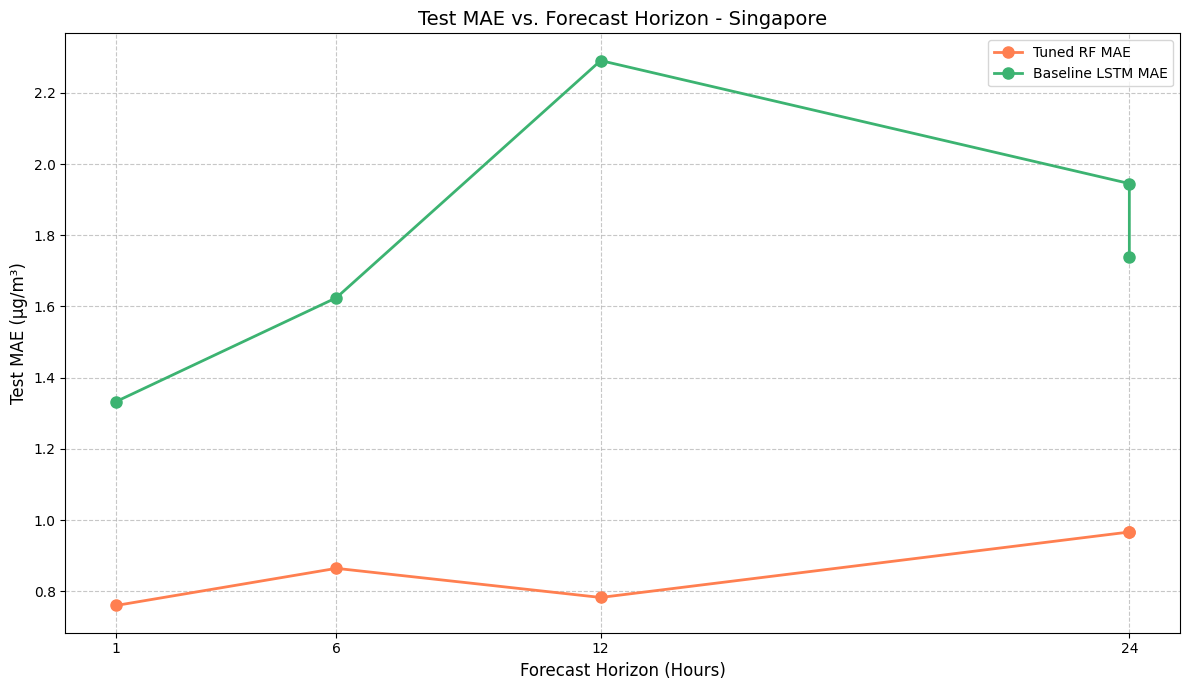

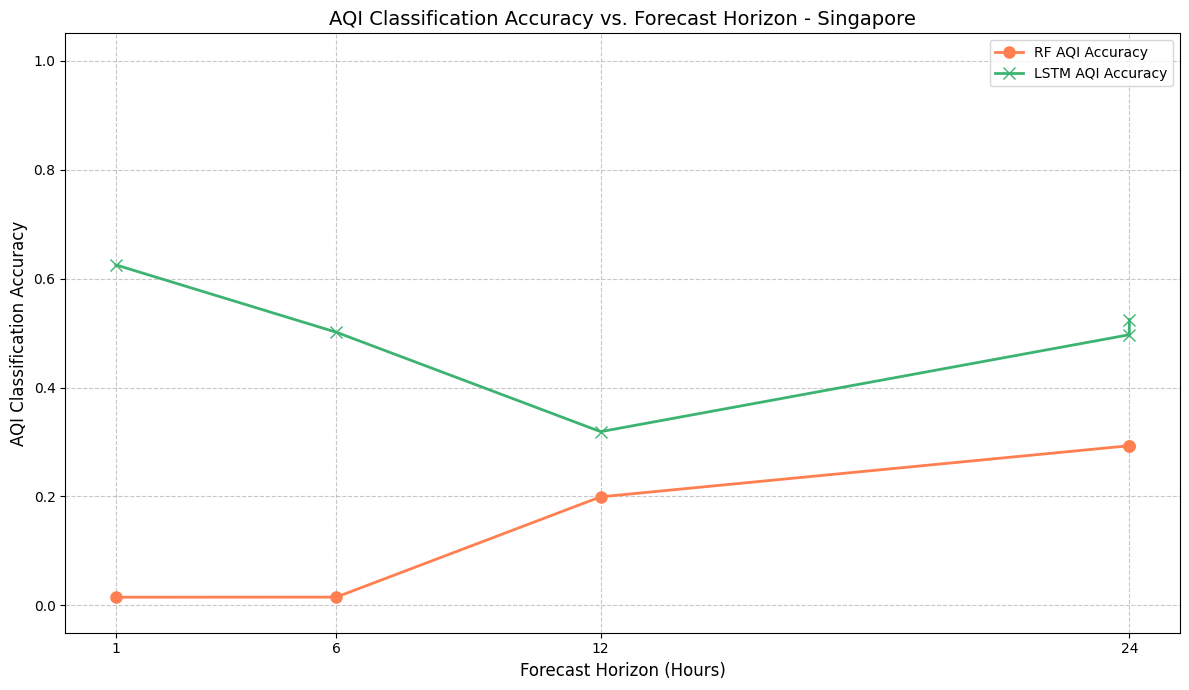

In [50]:
# Ensure this entire block is at the correct indentation level (i.e., after the main for loop has finished)

# --- After Loop: Consolidate and Display Multi-Horizon Results ---
if all_results_across_horizons:
    multi_horizon_results_df = pd.DataFrame(all_results_across_horizons)
    multi_horizon_results_df = multi_horizon_results_df.round(4)
    print("\n\n===== MULTI-HORIZON FORECASTING RESULTS SUMMARY =====")
    print(multi_horizon_results_df)
    multi_horizon_summary_file = f'sensor_{sensors_id}_{location_name}_multi_horizon_summary.csv'
    multi_horizon_results_df.to_csv(multi_horizon_summary_file, index=False)
    print(f"\nSaved multi-horizon summary to {multi_horizon_summary_file}")

    # Plot MAE vs Horizon
    plt.figure(figsize=(12, 7))
    model_colors = {
        'Tuned RF': 'coral',
        'Baseline LSTM': 'mediumseagreen',
        'LSTM (Dynamic Quant)': 'skyblue',
        'LSTM (Float16 Quant)': 'dodgerblue',
        'Simplified RF': 'lightcoral'
    }
    plotted_mae = False
    for model_type_unique in multi_horizon_results_df['Model Type'].unique():
        subset = multi_horizon_results_df[multi_horizon_results_df['Model Type'] == model_type_unique]
        if 'MAE' in subset.columns and not subset['MAE'].dropna().empty:
            plt.plot(subset['Horizon'], subset['MAE'], marker='o', label=f'{model_type_unique} MAE', color=model_colors.get(model_type_unique, 'gray'), linewidth=2, markersize=8)
            plotted_mae = True

    plt.xlabel('Forecast Horizon (Hours)', fontsize=12)
    plt.ylabel('Test MAE (µg/m³)', fontsize=12)
    plt.title(f'Test MAE vs. Forecast Horizon - {location_name}', fontsize=14)
    if plotted_mae:
        plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(forecast_horizons_to_test)
    plt.tight_layout()
    plt.savefig(f'sensor_{sensors_id}_{location_name}_mae_vs_horizon.png')
    plt.show()

    # Plot AQI Accuracy vs Horizon
    # Check if relevant columns exist and have data before attempting to plot
    aqi_rf_col = 'AQI Accuracy (RF)'
    aqi_lstm_col = 'AQI Accuracy (LSTM)'

    rf_has_aqi_data = (aqi_rf_col in multi_horizon_results_df.columns and
                       not multi_horizon_results_df[multi_horizon_results_df['Model Type']=='Tuned RF'][aqi_rf_col].dropna().empty)

    lstm_has_aqi_data = (aqi_lstm_col in multi_horizon_results_df.columns and
                         not multi_horizon_results_df[multi_horizon_results_df['Model Type']=='Baseline LSTM'][aqi_lstm_col].dropna().empty)

    plotted_aqi_acc = False
    if rf_has_aqi_data or lstm_has_aqi_data: # Plot if either RF or LSTM has AQI data
        plt.figure(figsize=(12, 7))

        if rf_has_aqi_data:
            rf_aqi_data_plot = multi_horizon_results_df[multi_horizon_results_df['Model Type']=='Tuned RF']
            plt.plot(rf_aqi_data_plot['Horizon'], rf_aqi_data_plot[aqi_rf_col], marker='o', label='RF AQI Accuracy', color=model_colors.get('Tuned RF', 'coral'), linewidth=2, markersize=8)
            plotted_aqi_acc = True

        if lstm_has_aqi_data:
            lstm_aqi_data_plot = multi_horizon_results_df[multi_horizon_results_df['Model Type']=='Baseline LSTM']
            plt.plot(lstm_aqi_data_plot['Horizon'], lstm_aqi_data_plot[aqi_lstm_col], marker='x', label='LSTM AQI Accuracy', color=model_colors.get('Baseline LSTM', 'mediumseagreen'), linewidth=2, markersize=8)
            plotted_aqi_acc = True

        plt.xlabel('Forecast Horizon (Hours)', fontsize=12)
        plt.ylabel('AQI Classification Accuracy', fontsize=12)
        plt.title(f'AQI Classification Accuracy vs. Forecast Horizon - {location_name}', fontsize=14)
        if plotted_aqi_acc:
            plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(-0.05, 1.05)
        plt.xticks(forecast_horizons_to_test)
        plt.tight_layout()
        plt.savefig(f'sensor_{sensors_id}_{location_name}_aqi_accuracy_vs_horizon.png')
        plt.show()
    else: # This 'else' corresponds to 'if rf_has_aqi_data or lstm_has_aqi_data:'
        print("No AQI Accuracy data (for original Tuned RF or Baseline LSTM) available to plot for comparison across horizons.")
else: # This 'else' corresponds to 'if all_results_across_horizons:'
    print("No results collected across horizons to summarize or plot.")

In [52]:
# --- Section 7 (continued): Model Compression (Applied to models from a chosen horizon, e.g., 6-hour) ---
chosen_horizon_for_compression = 6 # This should match one of the horizons processed in the loop
print(f"\n\n===== MODEL COMPRESSION FOR FORECAST HORIZON: {chosen_horizon_for_compression} HOURS ======")

# File names for models and scalers from the chosen horizon
tuned_rf_model_filename_comp = f'sensor_{sensors_id}_{location_name}_rf_model_tuned_h{chosen_horizon_for_compression}.joblib'
lstm_model_filename_comp = f'sensor_{sensors_id}_{location_name}_lstm_model_baseline_h{chosen_horizon_for_compression}.keras'
scaler_x_filename_comp = f'sensor_{sensors_id}_{location_name}_scaler_X_h{chosen_horizon_for_compression}.joblib'
scaler_y_filename_comp = f'sensor_{sensors_id}_{location_name}_scaler_y_h{chosen_horizon_for_compression}.joblib'

# Initialize dataframes/series for this compression cell
X_train_comp, y_train_comp = pd.DataFrame(), pd.Series(dtype='float64')
X_test_comp, y_test_comp = pd.DataFrame(), pd.Series(dtype='float64') # This will be our ground truth for compression evaluation
X_test_reshaped_comp = None
feature_cols_for_comp_fe = []

# Re-generate train/test data specifically for compression to ensure consistency
if not df_for_eda.empty: # df_for_eda should be the globally available dataframe after EDA
    print(f"Re-generating train/test data specifically for compression (horizon {chosen_horizon_for_compression}h).")
    df_for_comp_fe = df_for_eda.copy()
    if 'pm25_value' not in df_for_comp_fe.columns:
        print(f"Error: 'pm25_value' column missing in df_for_eda. Cannot proceed with FE for compression.")
    else:
        df_for_comp_fe['target_pm25'] = df_for_comp_fe['pm25_value'].shift(-chosen_horizon_for_compression)
        num_pm25_lags_comp = 5
        for i in range(1, num_pm25_lags_comp + 1):
            col_name = f'pm25_lag_{i}'
            df_for_comp_fe[col_name] = df_for_comp_fe['pm25_value'].shift(i)
            feature_cols_for_comp_fe.append(col_name)

        weather_features_comp_list = ['temp', 'humidity', 'wind_speed', 'wind_dir', 'precipitation']
        num_weather_lags_comp = 2
        for wf in weather_features_comp_list:
            if wf in df_for_comp_fe.columns:
                for i in range(1, num_weather_lags_comp + 1):
                    lag_col_name = f'{wf}_lag_{i}'
                    df_for_comp_fe[lag_col_name] = df_for_comp_fe[wf].shift(i)
                    feature_cols_for_comp_fe.append(lag_col_name)

        df_for_comp_fe['hour'] = df_for_comp_fe.index.hour
        df_for_comp_fe['dayofweek'] = df_for_comp_fe.index.dayofweek
        df_for_comp_fe['month'] = df_for_comp_fe.index.month
        feature_cols_for_comp_fe.extend(['hour', 'dayofweek', 'month'])

        df_for_comp_fe.dropna(inplace=True) # Drop rows with NaNs created by lagging

        if not df_for_comp_fe.empty:
            feature_cols_for_comp_fe = [col for col in feature_cols_for_comp_fe if col in df_for_comp_fe.columns]
            print(f"Actual features for compression FE (h{chosen_horizon_for_compression}): {feature_cols_for_comp_fe}")

            if not feature_cols_for_comp_fe:
                 print(f"No feature columns defined after FE for compression (h{chosen_horizon_for_compression}). Skipping compression for this horizon.")
            else:
                X_comp_all = df_for_comp_fe[feature_cols_for_comp_fe]
                y_comp_all = df_for_comp_fe['target_pm25']
                total_samples_comp = len(X_comp_all)

                if total_samples_comp > 60: # Ensure enough samples
                    # Using a slightly different split for compression evaluation to ensure enough test data
                    # but ideally, one would use the exact same test set as the main loop by saving/loading it.
                    # For simplicity here, we re-split.
                    # Ensure y_test_comp has an index for later alignment.
                    X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(
                        X_comp_all, y_comp_all, test_size=0.3, shuffle=False # Using 30% for test, no shuffle for time series
                    )

                    print(f"Train/Test data shapes for compression (h{chosen_horizon_for_compression}):")
                    print(f"X_train_comp: {X_train_comp.shape}, y_train_comp: {y_train_comp.shape}")
                    print(f"X_test_comp: {X_test_comp.shape}, y_test_comp: {y_test_comp.shape}")


                    if os.path.exists(scaler_x_filename_comp):
                        scaler_X_comp_loaded = joblib.load(scaler_x_filename_comp)
                        try:
                            # Ensure columns align with what the scaler expects
                            X_test_comp_aligned = X_test_comp.copy()
                            missing_cols = set(scaler_X_comp_loaded.feature_names_in_) - set(X_test_comp_aligned.columns)
                            for c in missing_cols: X_test_comp_aligned[c] = 0 # Or mean/median from X_train_comp[c]
                            X_test_comp_aligned = X_test_comp_aligned[scaler_X_comp_loaded.feature_names_in_]

                            X_test_scaled_comp = scaler_X_comp_loaded.transform(X_test_comp_aligned)
                            X_test_reshaped_comp = X_test_scaled_comp.reshape((X_test_scaled_comp.shape[0], 1, X_test_scaled_comp.shape[1]))
                            print(f"X_test_reshaped_comp for LSTM compression created. Shape: {X_test_reshaped_comp.shape}")
                        except Exception as e:
                            print(f"Error during scaling/reshaping X_test_comp for compression: {e}")
                            X_test_reshaped_comp = None
                    else:
                        print(f"Scaler X for h{chosen_horizon_for_compression} (file: {scaler_x_filename_comp}) not found. Cannot create X_test_reshaped_comp.")
                        X_test_reshaped_comp = None
                else:
                    print(f"Not enough data after FE for compression (h{chosen_horizon_for_compression}) for splits. Min 60 required, got {total_samples_comp}.")
        else:
            print(f"DataFrame empty after FE and dropna during compression data prep (h{chosen_horizon_for_compression}).")
else:
    print("df_for_eda is empty. Cannot generate data for compression.")

# Load original models for compression
rf_model_loaded_comp = None
lstm_model_loaded_comp = None
scaler_y_loaded_comp = None

if os.path.exists(tuned_rf_model_filename_comp):
    rf_model_loaded_comp = joblib.load(tuned_rf_model_filename_comp)
if os.path.exists(lstm_model_filename_comp):
    lstm_model_loaded_comp = load_model(lstm_model_filename_comp)
if os.path.exists(scaler_y_filename_comp):
    scaler_y_loaded_comp = joblib.load(scaler_y_filename_comp)

compression_results_summary = []

# Ground truth AQI categories for the compression test set
y_test_comp_aqi_cats = pd.Series(dtype=str)
if not y_test_comp.empty:
    y_test_comp_aqi_values = y_test_comp.apply(calculate_pm25_aqi).dropna()
    y_test_comp_aqi_cats = y_test_comp_aqi_values.apply(get_aqi_category)
else:
    print("y_test_comp is empty, cannot generate ground truth AQI categories for compression evaluation.")

# --- LSTM Compression ---
if lstm_model_loaded_comp is not None and X_test_reshaped_comp is not None and not y_test_comp.empty and scaler_y_loaded_comp is not None and not y_test_comp_aqi_cats.empty:
    print(f"\n--- Compressing LSTM Model (h{chosen_horizon_for_compression}) using TFLite ---")

    # TFLite Model 1: Dynamic Range Quantization
    tflite_dynamic_quant_model_filename_comp = f'sensor_{sensors_id}_{location_name}_lstm_model_dynamic_quant_h{chosen_horizon_for_compression}.tflite'
    print("\n--- Dynamic Range Quantization ---")
    try:
        converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(lstm_model_loaded_comp)
        converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
        converter_dynamic.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
        tflite_dynamic_quant_model_content = converter_dynamic.convert()
        with open(tflite_dynamic_quant_model_filename_comp, 'wb') as f: f.write(tflite_dynamic_quant_model_content)
        print(f"Dynamic Range Quantized TFLite model saved to {tflite_dynamic_quant_model_filename_comp}")

        interpreter_dynamic = tf.lite.Interpreter(model_path=tflite_dynamic_quant_model_filename_comp)
        interpreter_dynamic.allocate_tensors()
        input_details_dynamic = interpreter_dynamic.get_input_details()
        output_details_dynamic = interpreter_dynamic.get_output_details()

        tflite_dynamic_preds_scaled = []
        start_time_tflite_dynamic = time.time()
        for i in range(len(X_test_reshaped_comp)):
            input_data = np.array(X_test_reshaped_comp[i:i+1], dtype=np.float32)
            interpreter_dynamic.set_tensor(input_details_dynamic[0]['index'], input_data)
            interpreter_dynamic.invoke()
            tflite_dynamic_preds_scaled.append(interpreter_dynamic.get_tensor(output_details_dynamic[0]['index'])[0])
        tflite_dynamic_pred_time = time.time() - start_time_tflite_dynamic

        y_pred_test_tflite_dynamic = scaler_y_loaded_comp.inverse_transform(np.array(tflite_dynamic_preds_scaled)).flatten() # Flatten to 1D array
        mae_test_tflite_dynamic = mean_absolute_error(y_test_comp, y_pred_test_tflite_dynamic)
        rmse_test_tflite_dynamic = np.sqrt(mean_squared_error(y_test_comp, y_pred_test_tflite_dynamic))
        tflite_dynamic_model_size = os.path.getsize(tflite_dynamic_quant_model_filename_comp) / (1024 * 1024)
        print(f"Dynamic Quant LSTM (h{chosen_horizon_for_compression}) - Test MAE: {mae_test_tflite_dynamic:.4f}, RMSE: {rmse_test_tflite_dynamic:.4f}")

        # AQI Evaluation for Dynamic Quant LSTM
        y_pred_dynamic_series = pd.Series(y_pred_test_tflite_dynamic, index=y_test_comp.index)
        y_pred_dynamic_aqi_values = y_pred_dynamic_series.apply(calculate_pm25_aqi).dropna()
        y_pred_dynamic_aqi_cats = y_pred_dynamic_aqi_values.apply(get_aqi_category)

        common_idx_dynamic = y_test_comp_aqi_cats.index.intersection(y_pred_dynamic_aqi_cats.index)
        aqi_acc_dynamic, aqi_f1_dynamic = np.nan, np.nan
        if not common_idx_dynamic.empty:
            report_dynamic = classification_report(y_test_comp_aqi_cats.loc[common_idx_dynamic], y_pred_dynamic_aqi_cats.loc[common_idx_dynamic], labels=aqi_categories_list, zero_division=0, output_dict=True)
            aqi_acc_dynamic = report_dynamic['accuracy']
            aqi_f1_dynamic = report_dynamic['weighted avg']['f1-score']
            print(f"  AQI Accuracy (Dynamic Quant LSTM): {aqi_acc_dynamic:.4f}, AQI F1: {aqi_f1_dynamic:.4f}")

        compression_results_summary.append({
            'Horizon': chosen_horizon_for_compression, 'Model Type': 'LSTM (Dynamic Quant)',
            'MAE': mae_test_tflite_dynamic, 'RMSE': rmse_test_tflite_dynamic,
            'Pred Time (s/sample)': tflite_dynamic_pred_time / len(X_test_reshaped_comp) if len(X_test_reshaped_comp) > 0 else 0,
            'Size (MB)': tflite_dynamic_model_size,
            'AQI Accuracy': aqi_acc_dynamic, 'AQI F1': aqi_f1_dynamic
        })
    except Exception as e:
        print(f"Error during LSTM Dynamic Range Quant (h{chosen_horizon_for_compression}): {e}")

    # TFLite Model 2: Float16 Quantization
    tflite_float16_quant_model_filename_comp = f'sensor_{sensors_id}_{location_name}_lstm_model_float16_quant_h{chosen_horizon_for_compression}.tflite'
    print("\n--- Float16 Quantization ---")
    try:
        converter_float16 = tf.lite.TFLiteConverter.from_keras_model(lstm_model_loaded_comp)
        converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
        converter_float16.target_spec.supported_types = [tf.float16]
        converter_float16.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
        tflite_float16_quant_model_content = converter_float16.convert()
        with open(tflite_float16_quant_model_filename_comp, 'wb') as f: f.write(tflite_float16_quant_model_content)
        print(f"Float16 Quantized TFLite model saved to {tflite_float16_quant_model_filename_comp}")

        interpreter_float16 = tf.lite.Interpreter(model_path=tflite_float16_quant_model_filename_comp)
        interpreter_float16.allocate_tensors()
        input_details_float16 = interpreter_float16.get_input_details()
        output_details_float16 = interpreter_float16.get_output_details()

        tflite_float16_preds_scaled = []
        start_time_tflite_float16 = time.time()
        for i in range(len(X_test_reshaped_comp)):
            input_data = np.array(X_test_reshaped_comp[i:i+1], dtype=np.float32)
            interpreter_float16.set_tensor(input_details_float16[0]['index'], input_data)
            interpreter_float16.invoke()
            tflite_float16_preds_scaled.append(interpreter_float16.get_tensor(output_details_float16[0]['index'])[0])
        tflite_float16_pred_time = time.time() - start_time_tflite_float16

        y_pred_test_tflite_float16 = scaler_y_loaded_comp.inverse_transform(np.array(tflite_float16_preds_scaled)).flatten() # Flatten
        mae_test_tflite_float16 = mean_absolute_error(y_test_comp, y_pred_test_tflite_float16)
        rmse_test_tflite_float16 = np.sqrt(mean_squared_error(y_test_comp, y_pred_test_tflite_float16))
        tflite_float16_model_size = os.path.getsize(tflite_float16_quant_model_filename_comp) / (1024 * 1024)
        print(f"Float16 Quant LSTM (h{chosen_horizon_for_compression}) - Test MAE: {mae_test_tflite_float16:.4f}, RMSE: {rmse_test_tflite_float16:.4f}")

        # AQI Evaluation for Float16 Quant LSTM
        y_pred_float16_series = pd.Series(y_pred_test_tflite_float16, index=y_test_comp.index)
        y_pred_float16_aqi_values = y_pred_float16_series.apply(calculate_pm25_aqi).dropna()
        y_pred_float16_aqi_cats = y_pred_float16_aqi_values.apply(get_aqi_category)

        common_idx_float16 = y_test_comp_aqi_cats.index.intersection(y_pred_float16_aqi_cats.index)
        aqi_acc_float16, aqi_f1_float16 = np.nan, np.nan
        if not common_idx_float16.empty:
            report_float16 = classification_report(y_test_comp_aqi_cats.loc[common_idx_float16], y_pred_float16_aqi_cats.loc[common_idx_float16], labels=aqi_categories_list, zero_division=0, output_dict=True)
            aqi_acc_float16 = report_float16['accuracy']
            aqi_f1_float16 = report_float16['weighted avg']['f1-score']
            print(f"  AQI Accuracy (Float16 LSTM): {aqi_acc_float16:.4f}, AQI F1: {aqi_f1_float16:.4f}")

        compression_results_summary.append({
            'Horizon': chosen_horizon_for_compression, 'Model Type': 'LSTM (Float16 Quant)',
            'MAE': mae_test_tflite_float16, 'RMSE': rmse_test_tflite_float16,
            'Pred Time (s/sample)': tflite_float16_pred_time / len(X_test_reshaped_comp) if len(X_test_reshaped_comp) > 0 else 0,
            'Size (MB)': tflite_float16_model_size,
            'AQI Accuracy': aqi_acc_float16, 'AQI F1': aqi_f1_float16
        })
    except Exception as e:
        print(f"Error during LSTM Float16 Quant (h{chosen_horizon_for_compression}): {e}")
else:
    print(f"Skipping LSTM compression for h{chosen_horizon_for_compression} due to missing prerequisites (model, data, scaler, or ground truth AQI cats).")

# --- Random Forest Compression (Simplification) ---
simplified_rf_model_filename_comp = f'sensor_{sensors_id}_{location_name}_rf_model_simplified_h{chosen_horizon_for_compression}.joblib'
if not X_train_comp.empty and not y_train_comp.empty and rf_model_loaded_comp is not None and not X_test_comp.empty and not y_test_comp.empty and not y_test_comp_aqi_cats.empty:
    print(f"\n--- Random Forest Model Simplification (h{chosen_horizon_for_compression}) ---")
    try:
        simplified_params_comp = rf_model_loaded_comp.get_params()
        if 'n_jobs' in simplified_params_comp: del simplified_params_comp['n_jobs']
        if 'random_state' in simplified_params_comp: del simplified_params_comp['random_state']

        simplified_params_comp['n_estimators'] = max(10, int(simplified_params_comp.get('n_estimators', 100) * 0.3))
        original_max_depth_comp_rf = simplified_params_comp.get('max_depth', None)
        simplified_params_comp['max_depth'] = max(5, int(original_max_depth_comp_rf * 0.5)) if original_max_depth_comp_rf else 10
        simplified_params_comp['min_samples_leaf'] = max(simplified_params_comp.get('min_samples_leaf', 1) * 2, 5)
        simplified_params_comp['min_samples_split'] = max(simplified_params_comp.get('min_samples_split', 2) * 2, 10)

        print(f"Simplified RF Params for h{chosen_horizon_for_compression}: {simplified_params_comp}")
        rf_model_simplified_comp = RandomForestRegressor(random_state=42, n_jobs=-1, **simplified_params_comp)

        rf_model_simplified_comp.fit(X_train_comp, y_train_comp)
        print("Simplified RF model training complete.")

        start_time_rf_simple = time.time()
        y_pred_test_rf_simple = rf_model_simplified_comp.predict(X_test_comp)
        rf_simple_prediction_time = time.time() - start_time_rf_simple

        mae_test_rf_simple = mean_absolute_error(y_test_comp, y_pred_test_rf_simple)
        rmse_test_rf_simple = np.sqrt(mean_squared_error(y_test_comp, y_pred_test_rf_simple))
        joblib.dump(rf_model_simplified_comp, simplified_rf_model_filename_comp)
        rf_simple_model_size = os.path.getsize(simplified_rf_model_filename_comp) / (1024 * 1024)
        print(f"Simplified RF (h{chosen_horizon_for_compression}) - Test MAE: {mae_test_rf_simple:.4f}, RMSE: {rmse_test_rf_simple:.4f}")

        # AQI Evaluation for Simplified RF
        y_pred_rf_simple_series = pd.Series(y_pred_test_rf_simple, index=y_test_comp.index)
        y_pred_rf_simple_aqi_values = y_pred_rf_simple_series.apply(calculate_pm25_aqi).dropna()
        y_pred_rf_simple_aqi_cats = y_pred_rf_simple_aqi_values.apply(get_aqi_category)

        common_idx_rf_simple = y_test_comp_aqi_cats.index.intersection(y_pred_rf_simple_aqi_cats.index)
        aqi_acc_rf_simple, aqi_f1_rf_simple = np.nan, np.nan
        if not common_idx_rf_simple.empty:
            report_rf_simple = classification_report(y_test_comp_aqi_cats.loc[common_idx_rf_simple], y_pred_rf_simple_aqi_cats.loc[common_idx_rf_simple], labels=aqi_categories_list, zero_division=0, output_dict=True)
            aqi_acc_rf_simple = report_rf_simple['accuracy']
            aqi_f1_rf_simple = report_rf_simple['weighted avg']['f1-score']
            print(f"  AQI Accuracy (Simplified RF): {aqi_acc_rf_simple:.4f}, AQI F1: {aqi_f1_rf_simple:.4f}")

        compression_results_summary.append({
            'Horizon': chosen_horizon_for_compression, 'Model Type': 'Simplified RF',
            'MAE': mae_test_rf_simple, 'RMSE': rmse_test_rf_simple,
            'Pred Time (s/sample)': rf_simple_prediction_time / len(X_test_comp) if len(X_test_comp) > 0 else 0,
            'Size (MB)': rf_simple_model_size,
            'AQI Accuracy': aqi_acc_rf_simple, 'AQI F1': aqi_f1_rf_simple
        })
    except Exception as e:
        print(f"Error during RF Simplification (h{chosen_horizon_for_compression}): {e}")
else:
    print(f"Skipping RF simplification for h{chosen_horizon_for_compression} due to missing prerequisites.")

# --- Summarize and Combine Compression Results ---
if compression_results_summary:
    compression_results_df = pd.DataFrame(compression_results_summary)
    print(f"\n--- Compression Results Summary (Horizon {chosen_horizon_for_compression}h) ---")
    print(compression_results_df.round(4))

    # Attempt to merge with main results DataFrame
    if 'all_results_across_horizons' in locals() and all_results_across_horizons:
        # Convert the list of dicts from main loop to DataFrame if not already
        if isinstance(all_results_across_horizons, list) and all(isinstance(item, dict) for item in all_results_across_horizons):
            main_loop_results_df = pd.DataFrame(all_results_across_horizons)
        elif isinstance(all_results_across_horizons, pd.DataFrame): # Should be multi_horizon_results_df from the loop's end
             main_loop_results_df = all_results_across_horizons # or multi_horizon_results_df if that's the final name
        else:
            main_loop_results_df = pd.DataFrame()
            print("Warning: 'all_results_across_horizons' is not in expected format for combining.")

        # For detailed comparison at the chosen horizon
        original_models_at_chosen_horizon = main_loop_results_df[
            (main_loop_results_df['Horizon'] == chosen_horizon_for_compression) &
            ((main_loop_results_df['Model Type'] == 'Tuned RF') | (main_loop_results_df['Model Type'] == 'Baseline LSTM'))
        ].copy() # Use .copy() to avoid SettingWithCopyWarning

        # The compression_results_df now has 'AQI Accuracy' and 'AQI F1' (generic)
        # The original_models_at_chosen_horizon has 'AQI Accuracy (RF)', 'AQI F1 (RF)', etc.
        # For the detailed comparison table, we can let concat handle this.
        # For the final table, we want all data.

        print(f"\n\n===== DETAILED COMPRESSION COMPARISON (Horizon {chosen_horizon_for_compression}h)=====")
        # For this table, it's okay if AQI columns from original and compressed are separate due to naming.
        # Or, we can rename compression_results_df's AQI cols to match the model type if desired for this specific table.
        # Example: if model_type is 'LSTM (Dynamic Quant)', rename 'AQI Accuracy' to 'AQI Accuracy (LSTM Quant)'
        # For now, let concat create separate columns which is informative.
        detailed_comparison_df = pd.concat([original_models_at_chosen_horizon, compression_results_df], ignore_index=True)
        print(detailed_comparison_df.round(4))
        compression_comparison_file = f'sensor_{sensors_id}_{location_name}_compression_comparison_h{chosen_horizon_for_compression}.csv'
        detailed_comparison_df.to_csv(compression_comparison_file, index=False)
        print(f"\nSaved compression comparison for h{chosen_horizon_for_compression} to {compression_comparison_file}")

        # For the final combined summary, we'll concatenate main_loop_results_df with compression_results_df
        # pd.concat will align common columns and add new ones where names differ (e.g. AQI Accuracy vs AQI Accuracy (RF))
        # This is acceptable.
        final_summary_df = pd.concat([main_loop_results_df, compression_results_df], ignore_index=True)
        # Clean up by trying to consolidate AQI columns if possible, or leave as is.
        # For simplicity, we leave them as potentially separate columns identified by Model Type.
        # Example: rows with Model Type 'Tuned RF' will have values in 'AQI Accuracy (RF)', others NaN in that column.
        # Rows with Model Type 'LSTM (Dynamic Quant)' will have values in 'AQI Accuracy', others NaN.

        # Remove exact duplicate rows if any were accidentally introduced
        final_summary_df.drop_duplicates(inplace=True)

        print("\n\n===== FINAL MULTI-HORIZON & COMPRESSION RESULTS SUMMARY =====")
        print(final_summary_df.round(4))
        final_summary_file = f'sensor_{sensors_id}_{location_name}_all_models_summary.csv'
        final_summary_df.to_csv(final_summary_file, index=False)
        print(f"\nSaved final combined summary to {final_summary_file}")

    else: # If main loop results aren't available for some reason
        print("Multi-horizon results (all_results_across_horizons) not available to combine with compression results.")
        compression_summary_file = f'sensor_{sensors_id}_{location_name}_compression_only_summary_h{chosen_horizon_for_compression}.csv'
        compression_results_df.to_csv(compression_summary_file, index=False)
        print(f"\nSaved compression-only summary for h{chosen_horizon_for_compression} to {compression_summary_file}")
else:
    print(f"\nNo compression results generated to summarize for horizon {chosen_horizon_for_compression}h.")



===== MODEL COMPRESSION FOR FORECAST HORIZON: 6 HOURS ======
Re-generating train/test data specifically for compression (horizon 6h).
Actual features for compression FE (h6): ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_lag_4', 'pm25_lag_5', 'temp_lag_1', 'temp_lag_2', 'humidity_lag_1', 'humidity_lag_2', 'wind_speed_lag_1', 'wind_speed_lag_2', 'wind_dir_lag_1', 'wind_dir_lag_2', 'precipitation_lag_1', 'precipitation_lag_2', 'hour', 'dayofweek', 'month']
Train/Test data shapes for compression (h6):
X_train_comp: (1524, 18), y_train_comp: (1524,)
X_test_comp: (654, 18), y_test_comp: (654,)
X_test_reshaped_comp for LSTM compression created. Shape: (654, 1, 18)

--- Compressing LSTM Model (h6) using TFLite ---

--- Dynamic Range Quantization ---
Saved artifact at '/tmp/tmpgbkmm1w_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 18), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dt